#Smoke Detection via Image Segmentation - Mosaicking the Dataset


---



This notebook showcases the dataset mosaicking and tiling for the segmentation model training. In the first notebook showcasing the analysis, we found that the dataset was complex due to the following reasons:<br>


1.  The first and second bands contain the smoke while the other four bands do not.
2.   The dataset has a wide range of image sizes
3.   Resizing using bicubic interpolation + augmentation was found to be ineffective and we need a better way to resize and create new images.
4. Common image processing techniques would not be viable for the given dataset to be changed into a usable form.

<br>Now we will implement mosaicking on the dataset in order to create a new image that combines all the dataset images and tile it into equal-sized images.


##Import Libraries

We will first install rasterio, which will be our primary module for handling with the GeoTIFF images.

In [ ]:
!pip install rasterio
!pip install -U tensorflow
!pip install -U keras

The dataset is stored on the Google Drive of Advith Krishnan

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


The following shows the necessary libraries that were imported.

In [ ]:
from PIL import Image
import re
import tensorflow as tf
import cv2
import matplotlib
import os
import rasterio as rio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rasterio.plot import show, show_hist
from sklearn.model_selection import train_test_split
import keras
from rasterio import warp
from rasterio import merge
from rasterio.windows import Window

In [ ]:
tifpath = "/content/drive/MyDrive/dataset/images/"
bmppath = "/content/drive/MyDrive/dataset/mask/"
bmpfol = []
tiffol=[]
for image in os.listdir(tifpath):
    tiffol.append(tifpath+image)
for _ in os.listdir(bmppath):
    bmpfol.append(bmppath+_)

tiffol = sorted(tiffol)
bmpfol = sorted(bmpfol)
print('Instances of Mask Dataset:',len(bmpfol))
print('\nInstances of Raster Image Dataset:',len(tiffol))

Instances of Mask Dataset: 352

Instances of Raster Image Dataset: 352


The dataset has a total of 352 image pairs of both rasters and segmentation masks.

##Affine Transformation data (Raster)


The affine transformation coefficients in Rasterio are a set of six numbers that define how pixel coordinates are mapped to world coordinates.<br><br>The coefficients are arranged in the following order:<br>
  A: The x-axis scaling factor<br>
  B: The x-axis offset.<br>
  C: The y-axis offset.<br>
  D: The y-axis scaling factor.<br>
  E: The x-skew.<br>
  F: The y-skew.<br>

In order to understand the ```Affine``` transformations of all the images in bulk, we found it to be easier to create a ```DataFrame``` that can store all the affine coefficients. The following shows the DataFrame of all the 352 images' affine transformations.

In [ ]:
cols = ["A","B","C","D","E","F"]
affines = pd.DataFrame(columns=cols)

In [ ]:
for i in tiffol:
  srt = rio.open(i)
  row = pd.DataFrame([srt.profile['transform'][0],srt.profile['transform'][1],srt.profile['transform'][2],srt.profile['transform'][3],srt.profile['transform'][4],srt.profile['transform'][5]]).T
  row.columns=cols
  affines = pd.concat([affines,row],ignore_index=True)

In [ ]:
affines

A    B       C    D         E      F
0    0.013636  0.0 -102.00  0.0 -0.010831  39.50
1    0.012766  0.0  -86.60  0.0 -0.010909  30.70
2    0.013462  0.0  -96.70  0.0 -0.010870  36.80
3    0.012575  0.0  -95.50  0.0 -0.010823  31.90
4    0.012195  0.0  -98.60  0.0 -0.010843  27.60
..        ...  ...     ...  ...       ...    ...
347  0.013939  0.0 -119.20  0.0 -0.010909  38.80
348  0.012903  0.0  -83.70  0.0 -0.010870  33.75
349  0.012727  0.0  -89.48  0.0 -0.010829  33.55
350  0.013491  0.0 -119.28  0.0 -0.010833  37.20
351  0.013793  0.0 -119.80  0.0 -0.010855  38.67

[352 rows x 6 columns]

In [ ]:
affines['B'].unique()

array([0.])

In [ ]:
affines['D'].unique()

array([0.])

If B and D are both 0 for all images, then all the affine transformations are simple scaling transformations. This means that the world coordinates are simply scaled by the values of A and C.

In [ ]:
datasample = affines.iloc[28]
datasample

A      0.013333
B      0.000000
C   -111.600000
D      0.000000
E     -0.010909
F     34.900000
Name: 28, dtype: float64

We can also use the ```DatasetReader.xy()``` function to check the exact coordinate values derived using the Affine transformations of an element of the image array.

In [ ]:
print(srt.xy(0, 0))

(-119.79310344827586, 38.66457264957265)


##Visualization (Raster)

Now let us take one of the GeoTIFF raster images as a sample for visualization.

In [ ]:
srtsample = rio.open(tiffol[0])

In [ ]:
plt.style.use('dark_background')

The following shows the first band of our sample image using ```rio.plot.show```, which allows us to combine the image array with the image transform that will plot it onto a Coordinate Reference System.<br>In our case, the raster images uses **EPSG:4326** which represents the **WGS84** coordinate reference system.

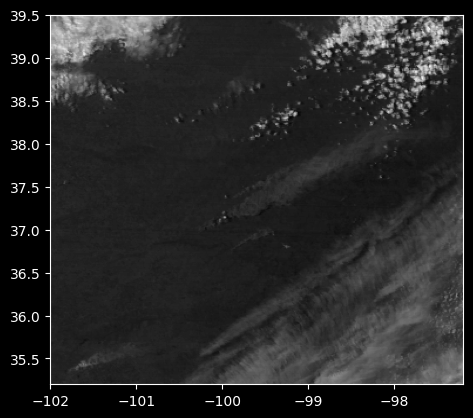

<function matplotlib.pyplot.show(close=None, block=None)>

In [ ]:
rio.plot.show(srtsample.read(1),transform=srtsample.transform,cmap="gray")
plt.show

In [ ]:
rio.open(tiffol[0]).read(1)

array([[118, 119, 111, ..., 133, 124, 124],
       [122, 121, 114, ..., 113, 116, 102],
       [123, 121, 116, ...,  90,  86,  91],
       ...,
       [ 77,  77,  76, ..., 111, 113, 116],
       [ 77,  76,  75, ..., 121, 119, 118],
       [ 76,  77,  77, ..., 123, 121, 117]], dtype=uint8)

We will now use ```rasterio.warp.reproject``` to reproject our images onto **EPSG:4326** and see the difference between the original and reprojected images.

In [ ]:
wgstifpath="/content/drive/MyDrive/wgs84/"
dst_crs = 'EPSG:4326'
for i in os.listdir(tifpath):
  with rio.open(tifpath+i) as src:
      transform, width, height = warp.calculate_default_transform(
          src.crs, dst_crs, src.width, src.height, *src.bounds)
      kwargs = src.meta.copy()
      kwargs.update({
          'crs': dst_crs,
          'transform': transform,
          'width': width,
          'height': height
      })

      with rio.open(wgstifpath+i, 'w', **kwargs) as dst:
          for j in range(1, src.count + 1):
              warp.reproject(
                  source=rio.band(src, j),
                  destination=rio.band(dst, j),
                  src_transform=src.transform,
                  src_crs=src.crs,
                  dst_transform=transform,
                  dst_crs=dst_crs,
                  resampling=warp.Resampling.nearest)

In [ ]:
rio.open("/content/drive/MyDrive/wgs84/time-20170652036101-loc--102.0_35.2_-97.2_39.5.tif").xy(0,0)

(-101.99392702151664, 39.49392702151663)

In [ ]:
rio.open("/content/drive/MyDrive/wgs84/time-20170652036101-loc--102.0_35.2_-97.2_39.5.tif").transform

Affine(0.012145956966727253, 0.0, -102.0,
       0.0, -0.012145956966727253, 39.5)

In [ ]:
wgstifs = sorted(os.listdir(wgstifpath))

In [ ]:
wgssample = rio.open(wgstifpath+wgstifs[0])

This is the first band of the original image.

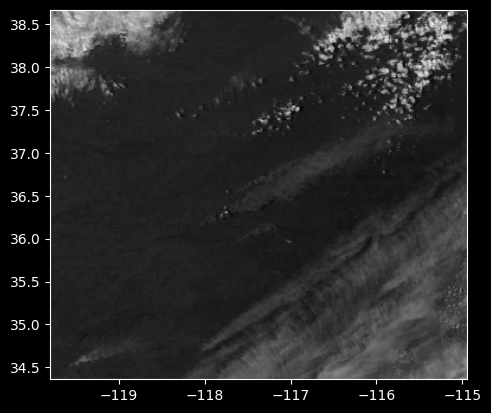

In [ ]:
rio.plot.show(srtsample.read(1),transform=srt.transform,cmap="gray")
plt.show()

This is the first band of the reprojected image.

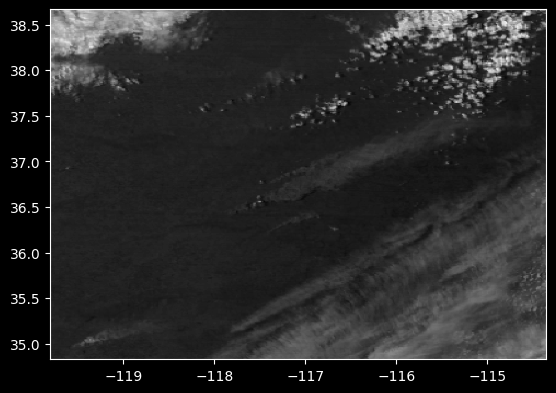

In [ ]:
rio.plot.show(wgssample.read(1),transform=srt.transform,cmap="gray")
plt.show()

The small difference in scale is caused due to the reprojection.

###Mosaics

Now it is time to mosaic all the raster images together and visualize them.

Now that we can project the images using its affine transformations and coordinate reference system, we can mosaic the images together and see the entirity of our dataset. We will use ```rasterio.merge.merge``` to mosaic together a list of all the ```Dataset``` objects to return the mosaic array and the mosaic geotransform.

In [ ]:
stuff_to_mosaic=[]
for i in os.listdir(tifpath):
  srt = rio.open(wgstifpath+i)
  stuff_to_mosaic.append(srt)

In [ ]:
mosaic,out_trans = merge.merge(stuff_to_mosaic)

The following shows the shape/size of the mosaic

In [ ]:
mosaic.shape

(6, 3813, 10206)

Now we can visualize all the six bands of the mosaic individually.

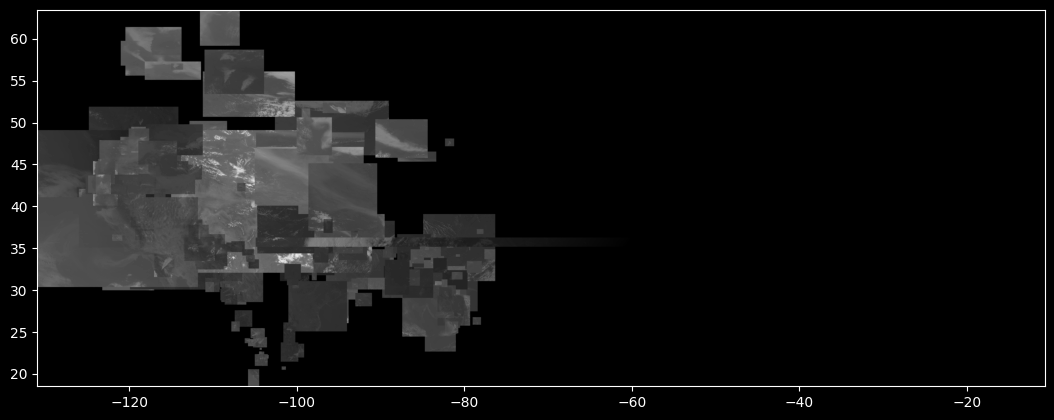

In [ ]:
plt.figure(figsize=(13,18))
show(mosaic[0],transform=out_trans,cmap="gray")
plt.show()

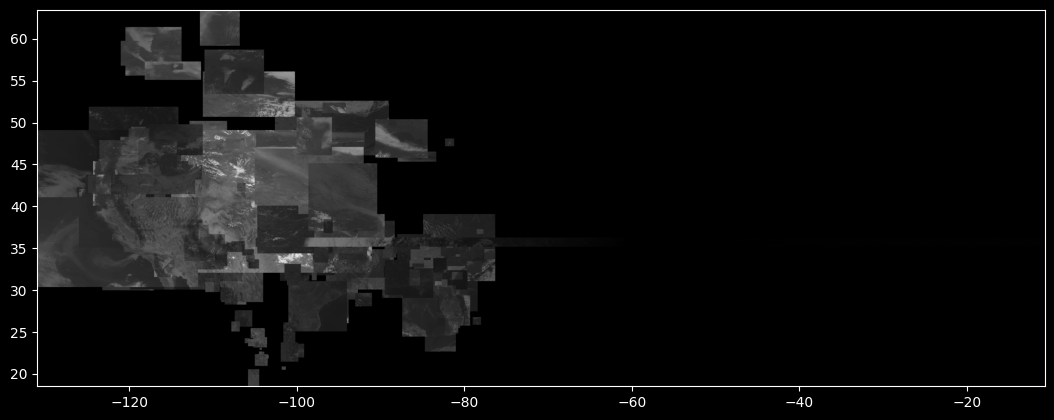

In [ ]:
plt.figure(figsize=(13,18))
show(mosaic[1],transform=out_trans,cmap="gray")
plt.show()

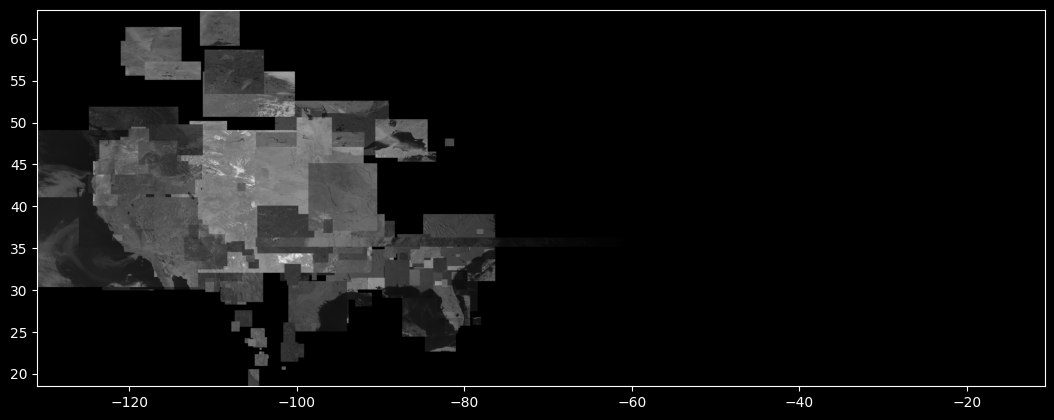

In [ ]:
plt.figure(figsize=(13,18))
show(mosaic[2],transform=out_trans,cmap="gray")
plt.show()

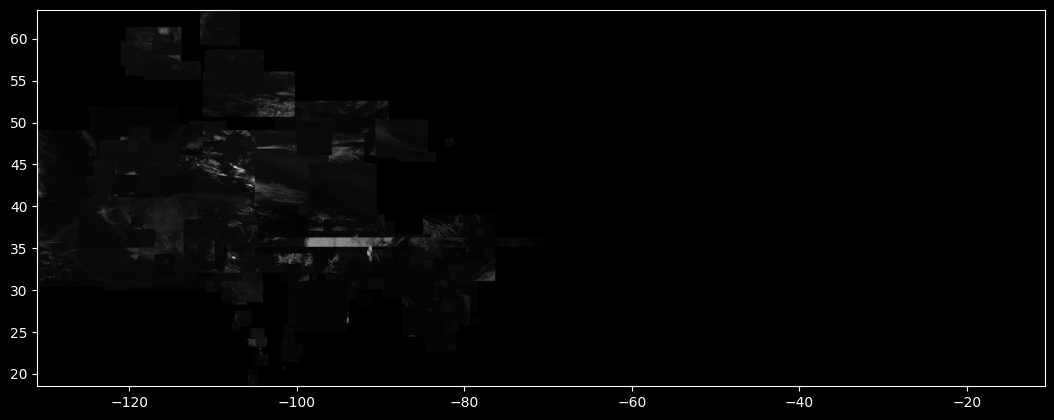

In [ ]:
plt.figure(figsize=(13,18))
show(mosaic[3],transform=out_trans,cmap="gray")
plt.show()

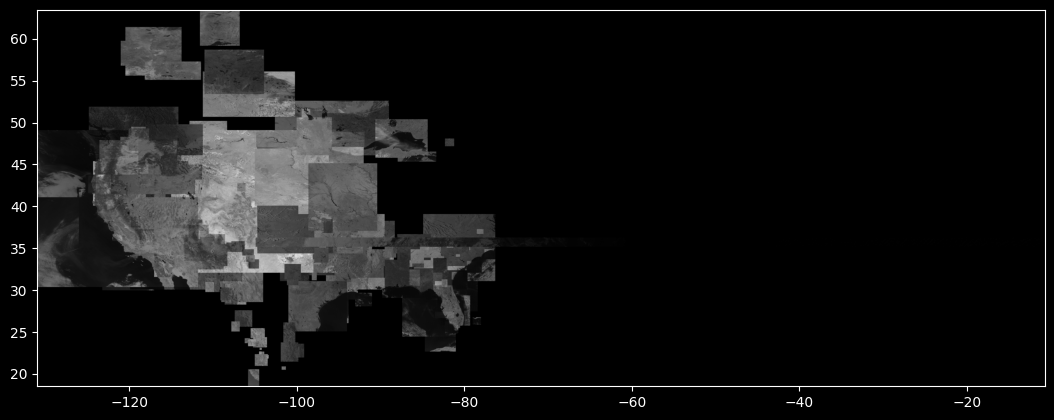

In [ ]:
plt.figure(figsize=(13,18))
show(mosaic[4],transform=out_trans,cmap="gray")
plt.show()

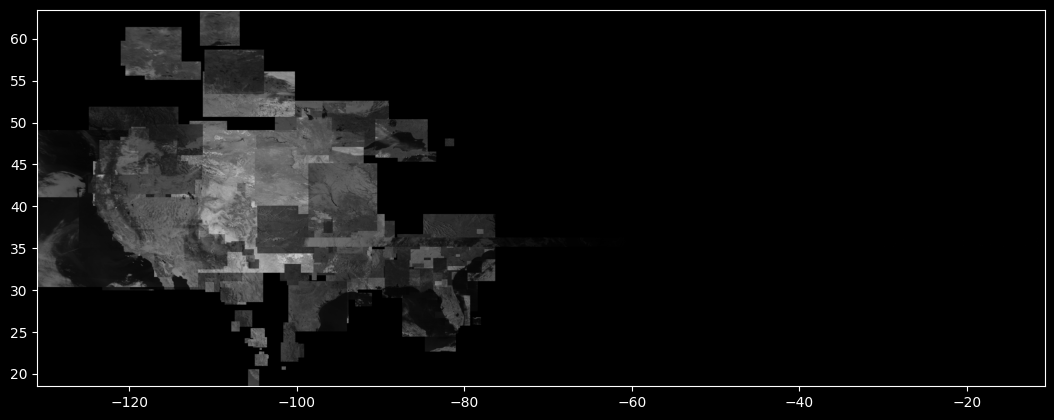

In [ ]:
plt.figure(figsize=(13,18))
show(mosaic[5],transform=out_trans,cmap="gray")
plt.show()

As we can see, the mosaic shows consistency and is able to display a large region of the United States. However, if we want to tile this image, we must omit the empty half of this mosaic in order to create tiles with necessary information.

##Redundant Image removal

###Dataset cleaning

In our preprocessing notebook, we found that one among the largest images in the dataset seemed to be redundant due to the fact that the mask showed no regions of smoke. We must hence remove it.<br>The following displays that very image.

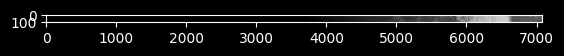

In [ ]:
plt.imshow(rio.open(tifpath + sorted(os.listdir(tifpath))[293]).read(1),cmap="gray")
plt.show()

In [ ]:
wgstifs = sorted(wgstifs)
redundant = wgstifs[293]

In [ ]:
cleaned_tifpath = sorted([wgstifpath+i for i in wgstifs])
cleaned_tifpath.remove(wgstifpath+redundant)

In [ ]:
len(cleaned_tifpath)

351

###Cleaned GeoTIFF Mosaic

Let us try creating a new cleaned mosaic and visualize that to see any changes

In [ ]:
cleaned_mosaic_stuff = []
for i in cleaned_tifpath:
  srt = rio.open(i)
  cleaned_mosaic_stuff.append(srt)

In [ ]:
cleaned_mosaic,cleanout_trans = merge.merge(cleaned_mosaic_stuff)

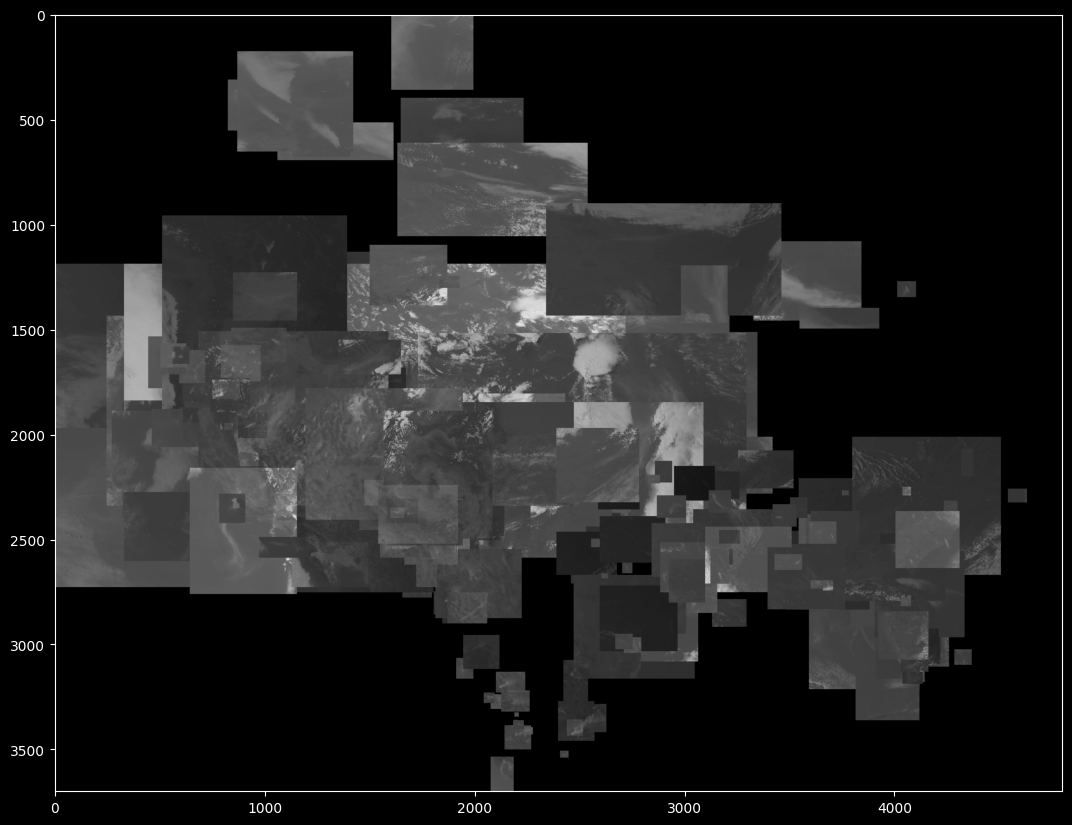

In [ ]:
plt.figure(figsize=(13,18))
plt.imshow(cleaned_mosaic[0],cmap="gray")
plt.xlim(0,4800)
plt.show()

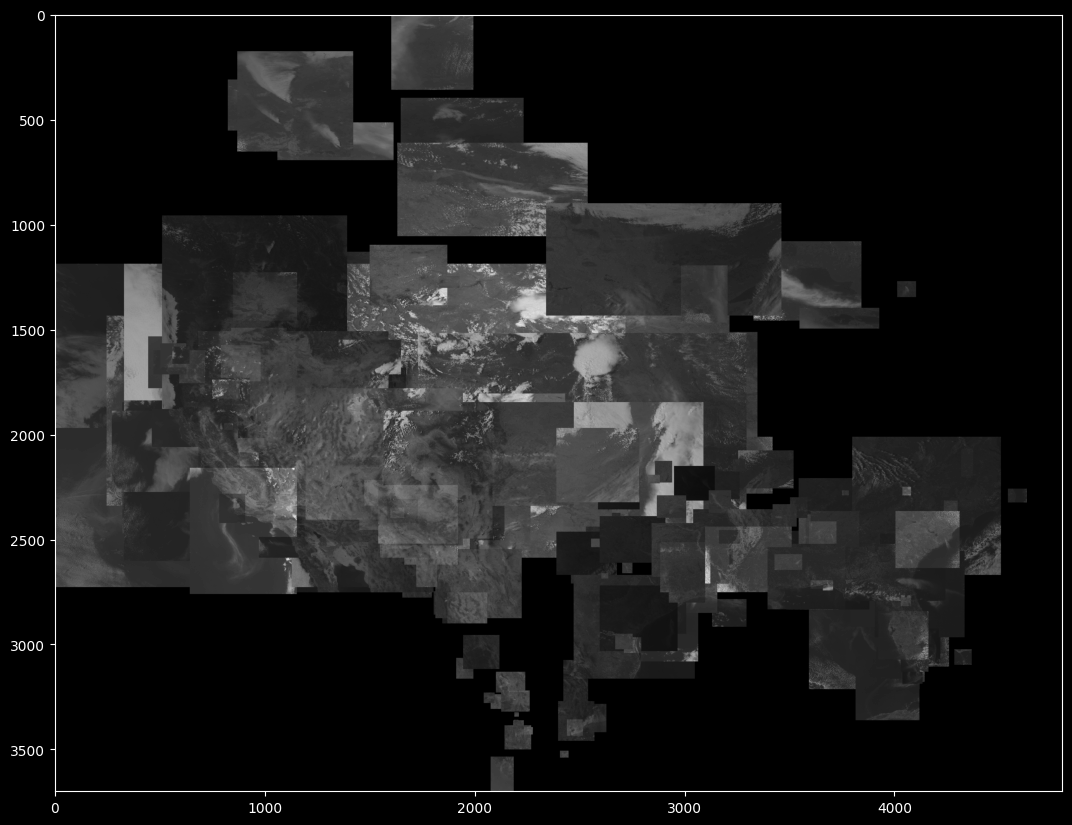

In [ ]:
plt.figure(figsize=(13,18))
plt.imshow(cleaned_mosaic[1],cmap="gray")
plt.xlim(0,4800)
plt.show()

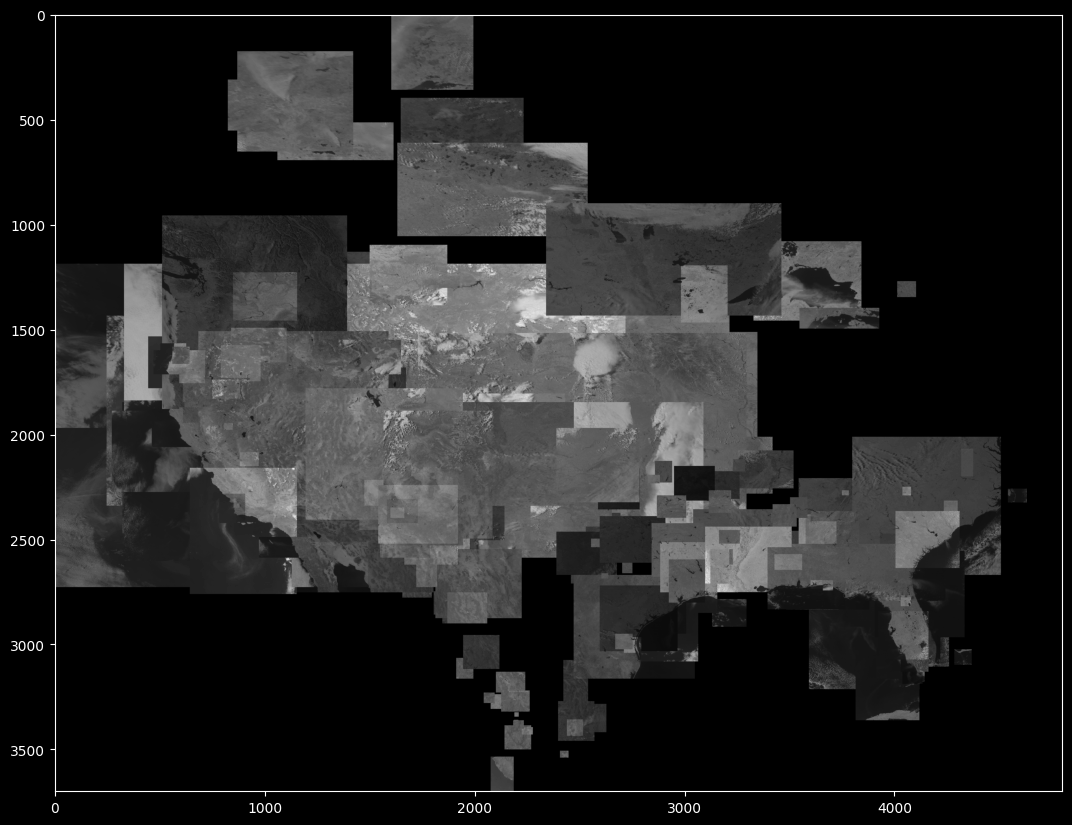

In [ ]:
plt.figure(figsize=(13,18))
plt.imshow(cleaned_mosaic[2],cmap="gray")
plt.xlim(0,4800)
plt.show()

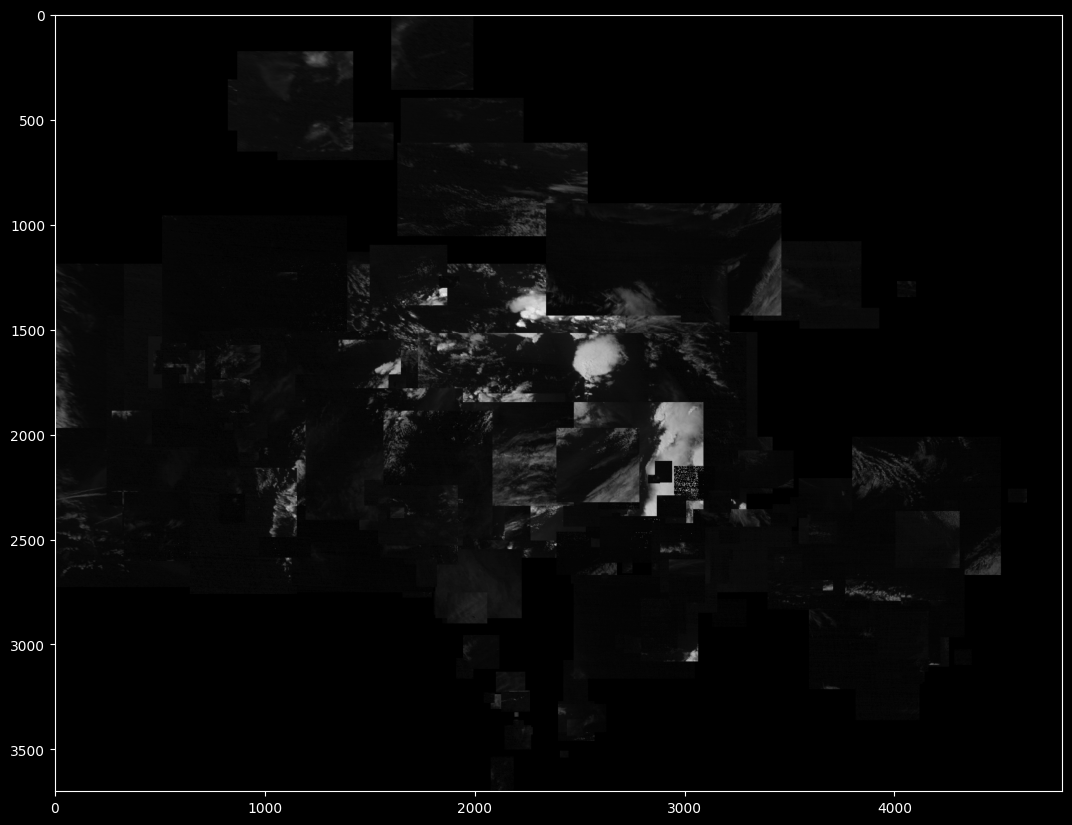

In [ ]:
plt.figure(figsize=(13,18))
plt.imshow(cleaned_mosaic[3],cmap="gray")
plt.xlim(0,4800)
plt.show()

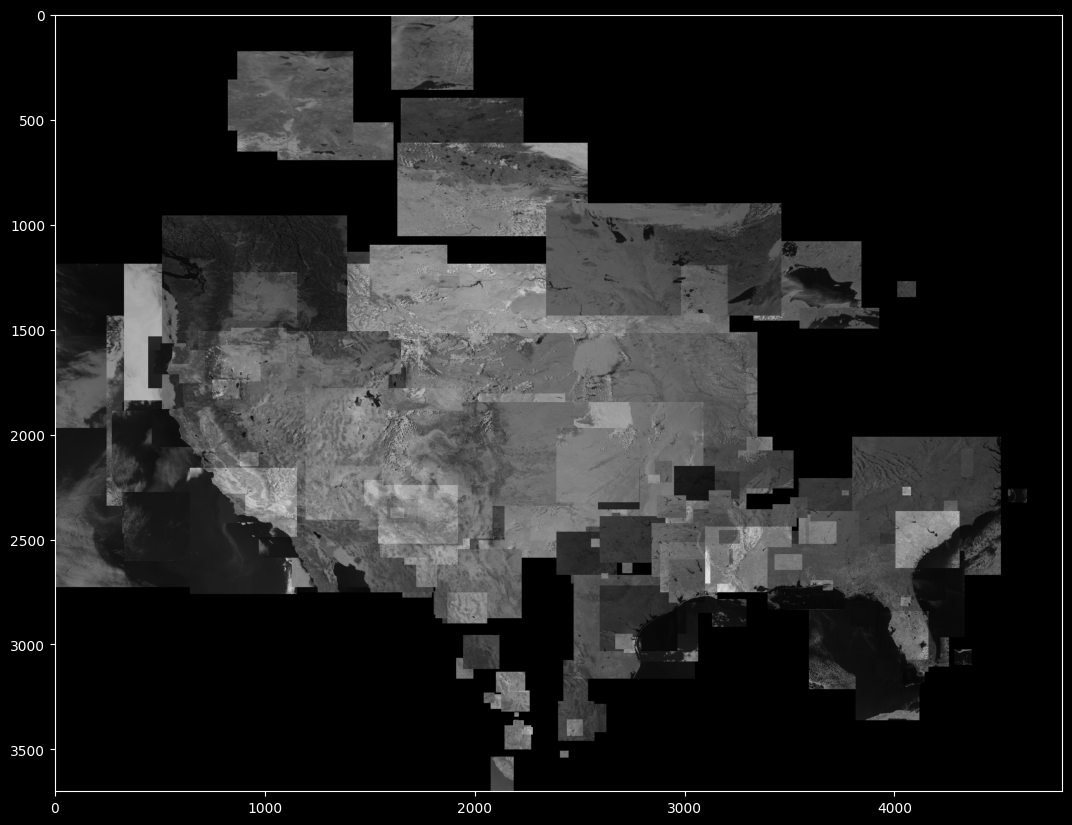

In [ ]:
plt.figure(figsize=(13,18))
plt.imshow(cleaned_mosaic[4],cmap="gray")
plt.xlim(0,4800)
plt.show()

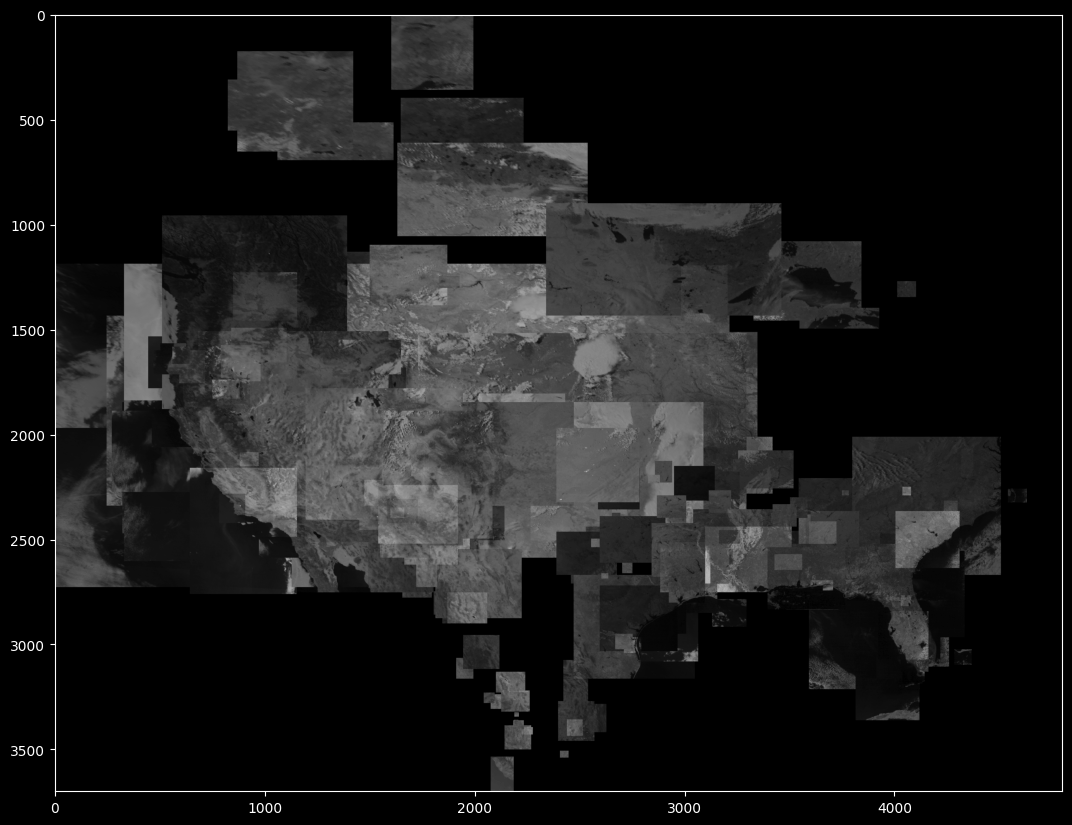

In [ ]:
plt.figure(figsize=(13,18))
plt.imshow(cleaned_mosaic[5],cmap="gray")
plt.xlim(0,4800)
plt.show()

As we can see, it eliminates a large portion of empty space, allowing us to use.

###Bitmap Cleaning

We will do the same as above for the bitmaps as well

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


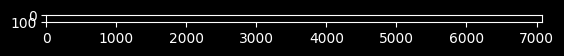

In [ ]:
plt.imshow(rio.open(bmppath + sorted(os.listdir(bmppath))[293]).read(1),cmap="gray")
plt.show()

In [ ]:
cleaned_bmps = sorted(os.listdir(bmppath))
redundant = cleaned_bmps[293]
redundant

'time-20191742310594-loc--10.7_35.1_-104.9_36.2.bmp'

In [ ]:
cleaned_bmps.remove(redundant)

##Affine Transformation data (Mask)

Now just like before, we will create a DataFrame for the affine transformations of all the mask images and see what we have.

In [ ]:
bitmap_mosaic_stuff=[]
for i in cleaned_bmps:
  srb = rio.open(bmppath+i)
  bitmap_mosaic_stuff.append(srb)

In [ ]:
cols = ["A","B","C","D","E","F"]
bmpaffines = pd.DataFrame(columns=cols)

In [ ]:
for i in bitmap_mosaic_stuff:
  row = pd.DataFrame([i.profile['transform'][0],i.profile['transform'][1],i.profile['transform'][2],i.profile['transform'][3],i.profile['transform'][4],i.profile['transform'][5]]).T
  row.columns=cols
  bmpaffines = pd.concat([bmpaffines,row],ignore_index=True)

In [ ]:
bmpaffines

A    B    C    D    E    F
0    1.0  0.0  0.0  0.0  1.0  0.0
1    1.0  0.0  0.0  0.0  1.0  0.0
2    1.0  0.0  0.0  0.0  1.0  0.0
3    1.0  0.0  0.0  0.0  1.0  0.0
4    1.0  0.0  0.0  0.0  1.0  0.0
..   ...  ...  ...  ...  ...  ...
346  1.0  0.0  0.0  0.0  1.0  0.0
347  1.0  0.0  0.0  0.0  1.0  0.0
348  1.0  0.0  0.0  0.0  1.0  0.0
349  1.0  0.0  0.0  0.0  1.0  0.0
350  1.0  0.0  0.0  0.0  1.0  0.0

[351 rows x 6 columns]

We seem to have the same Affine transformation for all the masks, which is **{1,0,0,0,1,0}**. This means that there is no scaling or transformation of any sort, which is true for BMP images. This becomes an issue if we want to create mosaics that correspond with the rasters.<br><br>The solution to this is to change these affine transforms into its corresponding raster's transform.

##Geospatial Referencing (Mask)

As mentioned previously, we must change the affines of the masks to match the rasters. Due to the following reasons, we have concluded that using the masks in the form of ```.bmp``` files would be ineffective:
*   BMP files are read-only and its metadata cannot be changed
*   While they are good for segmentation use-cases, we cannot plot it onto a coordinate system, due to the lack of affine transformations and reference coordinate systems.<br><br>

We have therefore decided to change the BMP files into GeoTIFF files for the convenience of performing geospatial referencing.



We will test this idea and demonstrate using the ```PIL``` library by creating an ```Image``` object from a sample BMP mask.

In [ ]:
img = Image.open('/content/drive/MyDrive/dataset/mask/time-20170652036101-loc--102.0_35.2_-97.2_39.5.bmp').convert('RGB')
img.save('x.tif', format='TIFF', compression='tiff_lzw')

In [ ]:
img = rio.open('x.tif')

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


As expected, the BMP converted TIFF file throws a ```NotGeoreferencedWarning``` due to the lack of geotransform, as the BMP file initially never had any, and we can see that in the metadata below.

In [ ]:
img.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 352,
 'height': 397,
 'count': 3,
 'crs': None,
 'transform': Affine(1.0, 0.0, 0.0,
        0.0, 1.0, 0.0)}

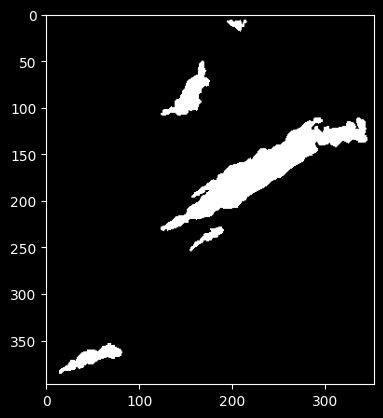

In [ ]:
show(img,transform=img.transform)
plt.show()

We can now change the Affine of this TIFF mask by creating a function that utilizes another TIFF file's metadata to change the mask metadata, thereby applying georeferences to it. The other TIFF will be its corresponding raster image file.

In [ ]:
def georeference_bitmap_mask(bitmap_mask, reference_raster):
  dst_crs = "EPSG:4326"
  with rio.open(reference_raster) as ref:
    transform, width, height = warp.calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)

    with rio.open(bitmap_mask,'r+',crs=dst_crs, transform = transform, width=width, height=height) as bmp:
      bmp.transform = ref.transform
      bmp.crs = ref.crs
      bmp.nodata = 0

In [ ]:
rio.open('x.tif').meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 352,
 'height': 397,
 'count': 3,
 'crs': None,
 'transform': Affine(1.0, 0.0, 0.0,
        0.0, 1.0, 0.0)}

In [ ]:
georeference_bitmap_mask("x.tif","/content/drive/MyDrive/dataset/images/time-20170652036101-loc--102.0_35.2_-97.2_39.5.tif")

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:306: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = get_writer_for_path(path, driver=driver)(


In [ ]:
rio.open('x.tif').read().max()

255

We will now visualize the image to see if everything is right.

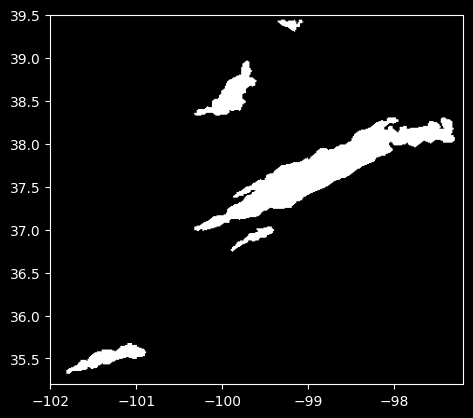

In [ ]:
show(rio.open('x.tif'),cmap='gray')
plt.show()

In [ ]:
rio.open('x.tif').meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 352,
 'height': 397,
 'count': 3,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.013636363636363629, 0.0, -102.0,
        0.0, -0.010831234256926945, 39.5)}

As you can see, the Affine of the raster image has been successfully applied to its corresponding mask image. We will now use this function to change all the masks.

In [ ]:
for i,j in zip(sorted(os.listdir("/content/drive/MyDrive/bmp")),sorted(os.listdir("/content/drive/MyDrive/dataset/images"))):
  georeference_bitmap_mask("/content/drive/MyDrive/bmp/"+ i,"/content/drive/MyDrive/dataset/images/"+j) #For reference, the new folder has masks with a single band instead of RGB

In [ ]:
rio.open(["/content/drive/MyDrive/bmp/"+i for i in sorted(os.listdir("/content/drive/MyDrive/bmp"))][0]).meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 352,
 'height': 397,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.013636363636363629, 0.0, -102.0,
        0.0, -0.010831234256926945, 39.5)}

BoundingBox(left=-102.0, bottom=35.2, right=-97.2, top=39.5) 



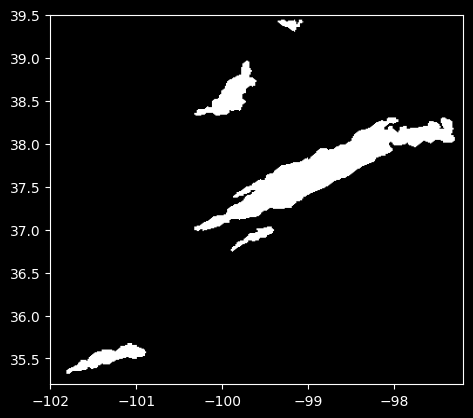

In [ ]:
smtgidk = rio.open(["/content/drive/MyDrive/bmp/"+i for i in sorted(os.listdir("/content/drive/MyDrive/bmp"))][0])
print(smtgidk.bounds,"\n")
show(smtgidk.read(),transform=smtgidk.transform,cmap="gray")
plt.show()

Now we can also reproject the masks using its new Affine transformation.

In [ ]:
def afftransform(srcpath,dstpath):
  with rio.open(srcpath) as src:
      transform, width, height = warp.calculate_default_transform(
          src.crs, dst_crs, src.width, src.height, *src.bounds)
      kwargs = src.meta.copy()
      kwargs.update({
          'crs': dst_crs,
          'transform': transform,
          'width': width,
          'height': height
      })

      with rio.open(dstpath, 'r+', **kwargs) as dst:
          for j in range(1, src.count + 1):
              warp.reproject(
                  source=rio.band(src, j),
                  destination=rio.band(dst, j),
                  src_transform=src.transform,
                  src_crs=src.crs,
                  dst_transform=transform,
                  dst_crs=dst_crs,
                  resampling=warp.Resampling.nearest)

In [ ]:
for i in sorted(os.listdir("/content/drive/MyDrive/bmp/")):
  afftransform("/content/drive/MyDrive/bmp/"+i,"/content/drive/MyDrive/bmp/"+i)

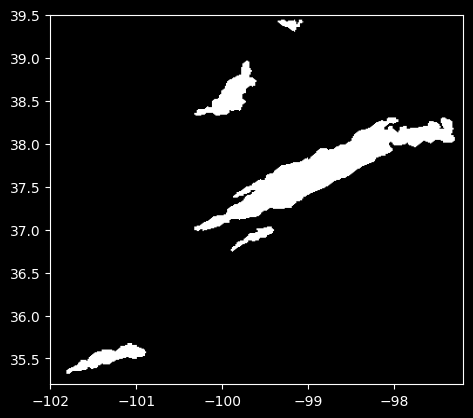

In [ ]:
smtgidk = rio.open("/content/drive/MyDrive/bmp/"+sorted(os.listdir("/content/drive/MyDrive/bmp/"))[0])
show(smtgidk.read(),transform=smtgidk.transform,cmap="gray")
plt.show()

In [ ]:
stuff_to_mosaic=[]
for i in sorted(os.listdir("/content/drive/MyDrive/bmp")):
  srt = rio.open("/content/drive/MyDrive/bmp/"+i,"r+")
  stuff_to_mosaic.append(srt)

In [ ]:
stuff_to_mosaic[10].meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 76,
 'height': 55,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.013157894736842105, 0.0, -89.6,
        0.0, -0.010909090909090934, 34.6)}

Let us create a new DataFrame of the masks containing the new Affines and see if they have been properly changed. We will check this by comparing the original Raster Affine transformation DataFrame with the Mask Affine Transformation DataFrame.

In [ ]:
cols = ["A","B","C","D","E","F"]
maskaffine = pd.DataFrame(columns=cols)

In [ ]:
for i in stuff_to_mosaic:
  row = pd.DataFrame([i.profile['transform'][0],i.profile['transform'][1],i.profile['transform'][2],i.profile['transform'][3],i.profile['transform'][4],i.profile['transform'][5]]).T
  row.columns=cols
  maskaffine = pd.concat([maskaffine,row],ignore_index=True)

In [ ]:
maskaffine.equals(affines)

True

Therefore the masks have been properly changed. We will do the same thing again but this time, we will check to see if the bounds are same.

In [ ]:
bcols = ["left","bottom","right","top","transform"]
bounds = pd.DataFrame(columns=bcols)
maskbounds = pd.DataFrame(columns=bcols)

In [ ]:
smtgidk.bounds

BoundingBox(left=-102.0, bottom=35.2, right=-97.2, top=39.5)

In [ ]:
for _ in sorted(os.listdir("/content/drive/MyDrive/dataset/images")):
  with rio.open("/content/drive/MyDrive/dataset/images/"+_) as i:
    row = pd.DataFrame([i.bounds.left,i.bounds.bottom,i.bounds.right,i.bounds.top,i.profile['transform']]).T
    row.columns=bcols
    bounds = pd.concat([bounds,row],ignore_index=True)

In [ ]:
for i in stuff_to_mosaic:
  row = pd.DataFrame([i.bounds.left,i.bounds.bottom,i.bounds.right,i.bounds.top,i.profile['transform']]).T
  row.columns=bcols
  maskbounds = pd.concat([maskbounds,row],ignore_index=True)

In [ ]:
bounds.head()

left bottom right   top                                          transform
0 -102.0   35.2 -97.2  39.5  (0.013636363636363629, 0.0, -102.0, 0.0, -0.01...
1  -86.6   30.1 -86.0  30.7  (0.01276595744680839, 0.0, -86.6, 0.0, -0.0109...
2  -96.7   36.3 -96.0  36.8  (0.013461538461538516, 0.0, -96.7, 0.0, -0.010...
3  -95.5   29.4 -93.4  31.9  (0.012574850299401164, 0.0, -95.5, 0.0, -0.010...
4  -98.6   26.7 -97.6  27.6  (0.012195121951219513, 0.0, -98.6, 0.0, -0.010...

In [ ]:
maskbounds.head()

left bottom right   top                                          transform
0 -102.0   35.2 -97.2  39.5  (0.013636363636363629, 0.0, -102.0, 0.0, -0.01...
1  -86.6   30.1 -86.0  30.7  (0.01276595744680839, 0.0, -86.6, 0.0, -0.0109...
2  -96.7   36.3 -96.0  36.8  (0.013461538461538516, 0.0, -96.7, 0.0, -0.010...
3  -95.5   29.4 -93.4  31.9  (0.012574850299401164, 0.0, -95.5, 0.0, -0.010...
4  -98.6   26.7 -97.6  27.6  (0.012195121951219513, 0.0, -98.6, 0.0, -0.010...

In [ ]:
maskbounds.equals(bounds)

True

With this confirmation, we can conclude that the masks have geospatial references that coincides with its coressponding raster images.

##Dataset Creation

###Creating Bitmap mosaics

We will first mosaic the masks together to check if the changes in Affine transformation cause any issues.

####Seperating inconsistent images

As previously demonstrated, we will mosaic using the ```rasterio.merge.merge``` function.

In [ ]:
stuff_to_mosaic = [rio.open("/content/drive/MyDrive/bmp/" + i) for i in sorted(os.listdir("/content/drive/MyDrive/bmp"))]
del stuff_to_mosaic[293] #This is the long image without any smoke region

In [ ]:
try:
  mosaic = merge.merge(stuff_to_mosaic)
except rio.errors.WindowError:
    print('"WindowError: Bounds and Transform are inconsistent" arises')

"WindowError: Bounds and Transform are inconsistent" arises


This is strange!! Despite using the same bounds and transforms as the GeoTIFF files, we are still hit with a WindowError when we mosaic all the masks while as shown previously, we didnt get this issue when we mosaicked the raster images.<br><br>The exact error message displays as follows:
```
/usr/local/lib/python3.10/dist-packages/rasterio/windows.py in from_bounds(left, bottom, right, top, transform, height, width, precision)
    320         raise WindowError("A transform object is required to calculate the window")
    321     if (right - left) / transform.a < 0:
--> 322         raise WindowError("Bounds and transform are inconsistent")
    323     if (bottom - top) / transform.e < 0:
    324         raise WindowError("Bounds and transform are inconsistent")

WindowError: Bounds and transform are inconsistent
```
According to the Rasterio documentation, the ```WindowError``` is <br>**'Raised when errors occur during window operations'**.<br><br>
This arises when dissimiliar masks overlapping over each other due to similiar bounds cause a conflict in the Window operations.<br>
This might be caused due to our modification of the BMP files, corrupting them.<br><br>
The solution to this issue would be to mosaic non-conflicting images and create multiple smaller mosaics instead of one large mosaic. We did this by creating sets of images within the whole dataset and ignoring the corrupted images.<br><br>
We first set some preliminary variables for  storing the conflicts, the output path and the count of mosaics created.

In [ ]:
conflicts = []
mosaiccount = 0
outpath = "/content/drive/MyDrive/mosaics/Masks/"

We then tested with small sets of images and iteratively increased the set till we were hit with the WindowError. The following show all the sets with the corrupted images in between each of the sets it affected.

Shape: (1302, 2171)


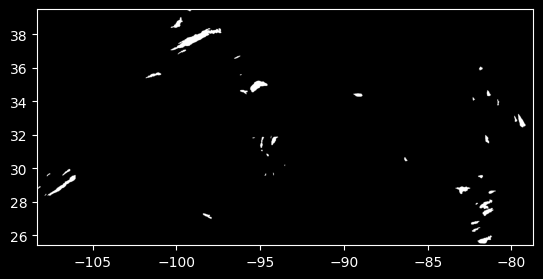

In [ ]:
try:
  mosaic,out_trans = merge.merge(stuff_to_mosaic[0:14])
  print("Shape:",mosaic[0].shape)
  show(mosaic,transform=out_trans,cmap="gray")
  plt.show()
  mosaiccount+=1
  with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=1,
            height= mosaic.shape[1],
            width= mosaic.shape[2],
            transform= out_trans,
            crs= src.crs,
            dtype= src.dtypes[0]) as dest:
    dest.write(mosaic)

except rio.errors.WindowError:
    print('"WindowError: Bounds and Transform are inconsistent" arises')

Shape: (46, 55)


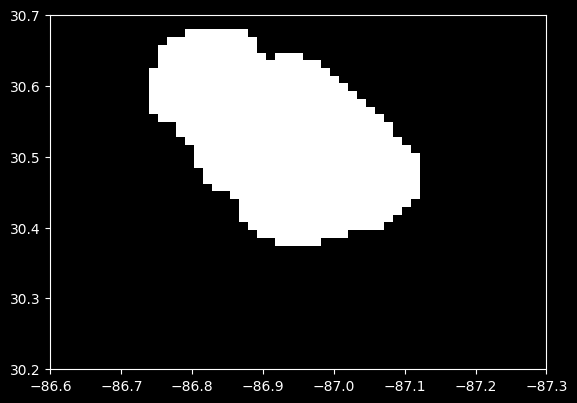

In [ ]:
print("Shape:",stuff_to_mosaic[14].read()[0].shape)
show(stuff_to_mosaic[14].read(),transform=stuff_to_mosaic[14].transform,cmap="gray")
conflicts.append(14)
plt.show()

Shape: (2243, 3605)


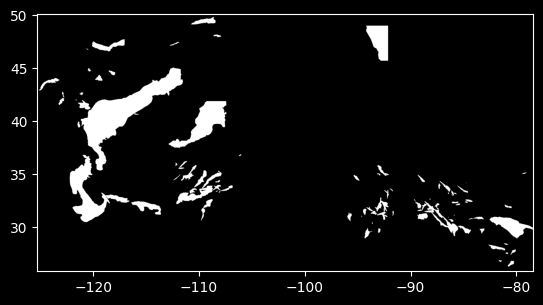

In [ ]:
try:
  mosaic,out_trans = merge.merge(stuff_to_mosaic[15:77])
  print("Shape:",mosaic[0].shape)
  show(mosaic,transform=out_trans,cmap="gray")
  plt.show()
  mosaiccount+=1
  with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=1,
            height= mosaic.shape[1],
            width= mosaic.shape[2],
            transform= out_trans,
            crs= src.crs,
            dtype= src.dtypes[0]) as dest:
    dest.write(mosaic)

except rio.errors.WindowError:
    print('"WindowError: Bounds and Transform are inconsistent" arises')

Shape: (138, 104)


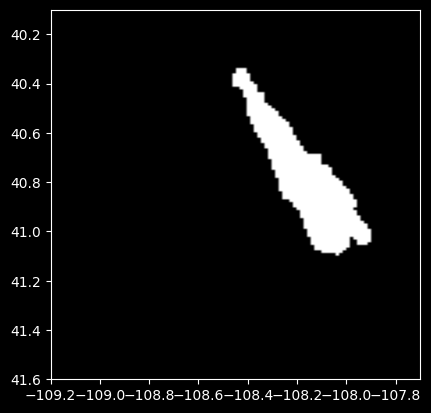

In [ ]:
print("Shape:",stuff_to_mosaic[77].read()[0].shape)
show(stuff_to_mosaic[77].read(),transform=stuff_to_mosaic[77].transform,cmap="gray")
conflicts.append(77)
plt.show()

Shape: (1789, 3038)


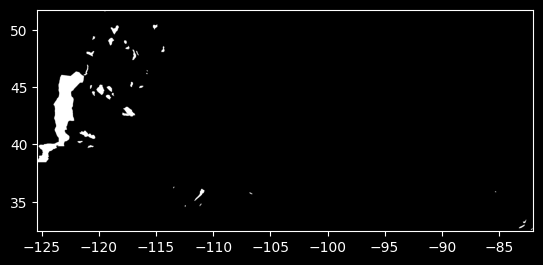

In [ ]:
try:
  mosaic,out_trans = merge.merge(stuff_to_mosaic[78:89])
  print("Shape:",mosaic[0].shape)
  show(mosaic,transform=out_trans,cmap="gray")
  plt.show()
  mosaiccount+=1
  with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=1,
            height= mosaic.shape[1],
            width= mosaic.shape[2],
            transform= out_trans,
            crs= src.crs,
            dtype= src.dtypes[0]) as dest:
    dest.write(mosaic)

except rio.errors.WindowError:
    print('"WindowError: Bounds and Transform are inconsistent" arises')

Shape: (110, 111)


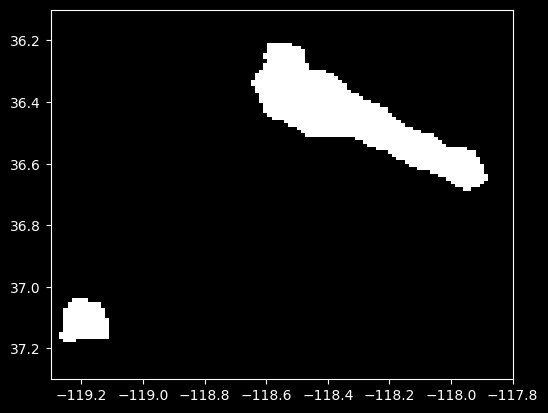

In [ ]:
print("Shape:",stuff_to_mosaic[89].read()[0].shape)
show(stuff_to_mosaic[89].read(),transform = stuff_to_mosaic[89].transform,cmap="gray")
conflicts.append(89)
plt.show()

Shape: (2389, 3628)


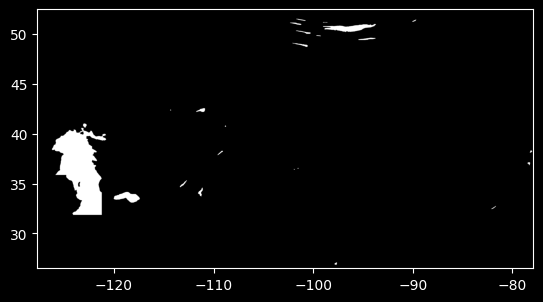

In [ ]:
try:
  mosaic,out_trans = merge.merge(stuff_to_mosaic[90:102])
  print("Shape:",mosaic[0].shape)
  show(mosaic,transform=out_trans,cmap="gray")
  plt.show()
  mosaiccount+=1
  with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=1,
            height= mosaic.shape[1],
            width= mosaic.shape[2],
            transform= out_trans,
            crs= src.crs,
            dtype= src.dtypes[0]) as dest:
    dest.write(mosaic)

except rio.errors.WindowError:
    print('"WindowError: Bounds and Transform are inconsistent" arises')

Shape: (740, 651)


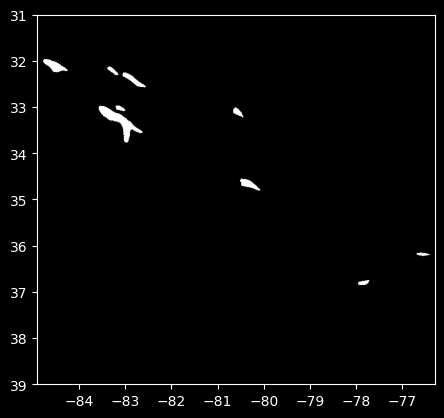

In [ ]:
print("Shape:",stuff_to_mosaic[102].read()[0].shape)
show(stuff_to_mosaic[102].read(),transform = stuff_to_mosaic[102].transform,cmap="gray")
conflicts.append(102)
plt.show()

Shape: (2053, 3570)


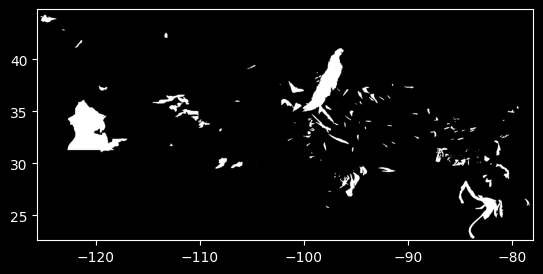

In [ ]:
try:
  mosaic,out_trans = merge.merge(stuff_to_mosaic[103:171])
  print("Shape:",mosaic[0].shape)
  show(mosaic,transform=out_trans,cmap="gray")
  plt.show()
  mosaiccount+=1
  with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=1,
            height= mosaic.shape[1],
            width= mosaic.shape[2],
            transform= out_trans,
            crs= src.crs,
            dtype= src.dtypes[0]) as dest:
    dest.write(mosaic)

except rio.errors.WindowError:
    print('"WindowError: Bounds and Transform are inconsistent" arises')

Shape: (157, 203)


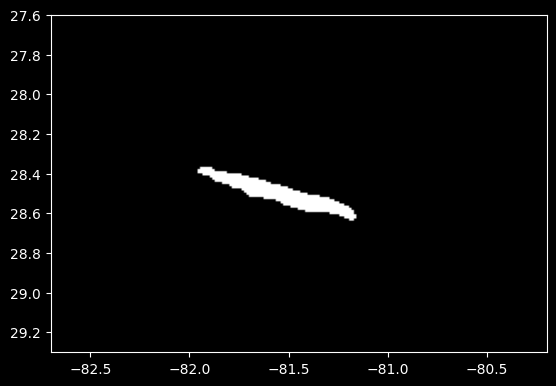

In [ ]:
print("Shape:",stuff_to_mosaic[171].read()[0].shape)
show(stuff_to_mosaic[171].read(),transform = stuff_to_mosaic[171].transform,cmap="gray")
conflicts.append(171)
plt.show()

Shape: (3121, 4309)


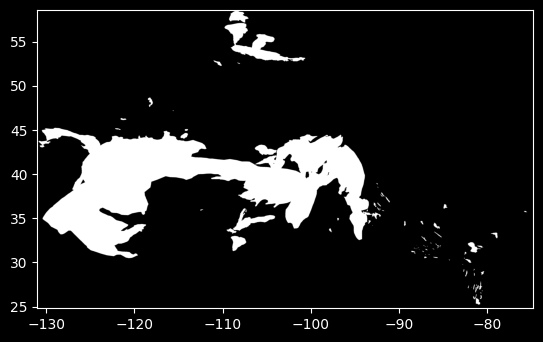

In [ ]:
try:
  mosaic,out_trans = merge.merge(stuff_to_mosaic[172:211])
  print("Shape:",mosaic[0].shape)
  show(mosaic,transform=out_trans,cmap="gray")
  plt.show()
  mosaiccount+=1
  with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=1,
            height= mosaic.shape[1],
            width= mosaic.shape[2],
            transform= out_trans,
            crs= src.crs,
            dtype= src.dtypes[0]) as dest:
    dest.write(mosaic)

except rio.errors.WindowError:
    print('"WindowError: Bounds and Transform are inconsistent" arises')

Shape: (148, 190)


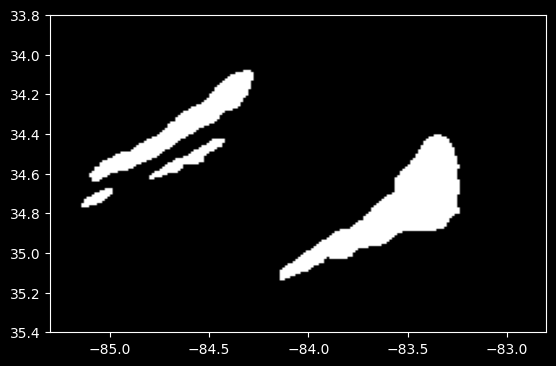

In [ ]:
print("Shape:",stuff_to_mosaic[211].read()[0].shape)
show(stuff_to_mosaic[211].read(),transform = stuff_to_mosaic[211].transform,cmap="gray")
conflicts.append(211)
plt.show()

Shape: (697, 1660)


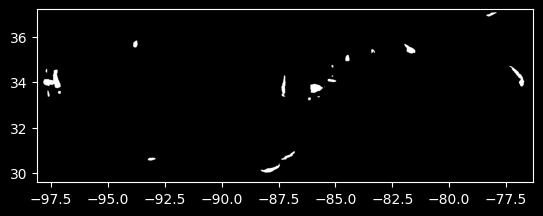

In [ ]:
try:
  mosaic,out_trans = merge.merge(stuff_to_mosaic[212:224])
  print("Shape:",mosaic[0].shape)
  show(mosaic,transform=out_trans,cmap="gray")
  plt.show()
  mosaiccount+=1
  with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=1,
            height= mosaic.shape[1],
            width= mosaic.shape[2],
            transform= out_trans,
            crs= src.crs,
            dtype= src.dtypes[0]) as dest:
    dest.write(mosaic)

except rio.errors.WindowError:
    print('"WindowError: Bounds and Transform are inconsistent" arises')

Shape: (101, 54)


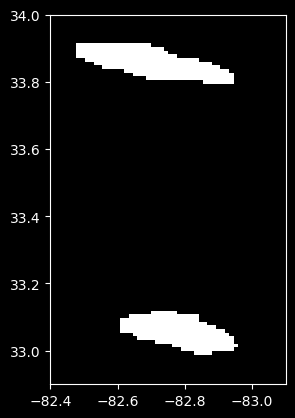

In [ ]:
print("Shape:",stuff_to_mosaic[224].read()[0].shape)
show(stuff_to_mosaic[224].read(),transform = stuff_to_mosaic[224].transform,cmap="gray")
conflicts.append(224)
plt.show()

Shape: (2658, 3124)


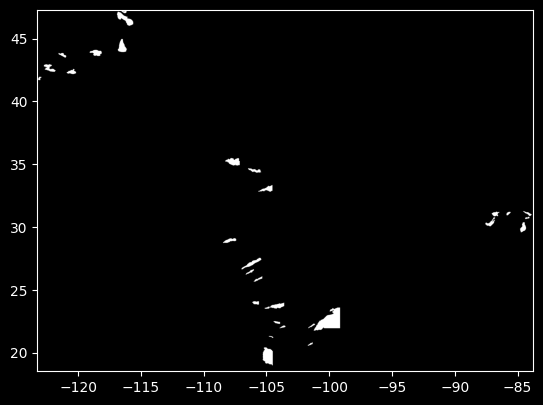

In [ ]:
try:
  mosaic,out_trans = merge.merge(stuff_to_mosaic[225:247])
  print("Shape:",mosaic[0].shape)
  show(mosaic,transform=out_trans,cmap="gray")
  plt.show()
  mosaiccount+=1
  with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=1,
            height= mosaic.shape[1],
            width= mosaic.shape[2],
            transform= out_trans,
            crs= src.crs,
            dtype= src.dtypes[0]) as dest:
    dest.write(mosaic)

except rio.errors.WindowError:
    print('"WindowError: Bounds and Transform are inconsistent" arises')

Shape: (29, 21)


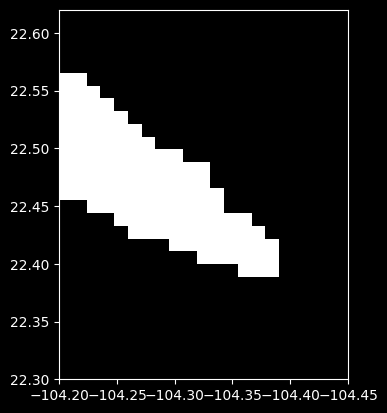

In [ ]:
print("Shape:",stuff_to_mosaic[247].read()[0].shape)
show(stuff_to_mosaic[247].read(),transform = stuff_to_mosaic[247].transform,cmap="gray")
conflicts.append(247)
plt.show()

Shape: (3915, 3732)


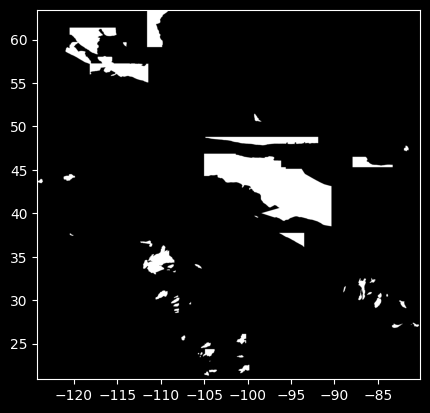

In [ ]:
try:
  mosaic,out_trans = merge.merge(stuff_to_mosaic[248:300])
  print("Shape:",mosaic[0].shape)
  show(mosaic,transform=out_trans,cmap="gray")
  plt.show()
  mosaiccount+=1
  with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=1,
            height= mosaic.shape[1],
            width= mosaic.shape[2],
            transform= out_trans,
            crs= src.crs,
            dtype= src.dtypes[0]) as dest:
    dest.write(mosaic)

except rio.errors.WindowError:
    print('"WindowError: Bounds and Transform are inconsistent" arises')

Shape: (2111, 3263)


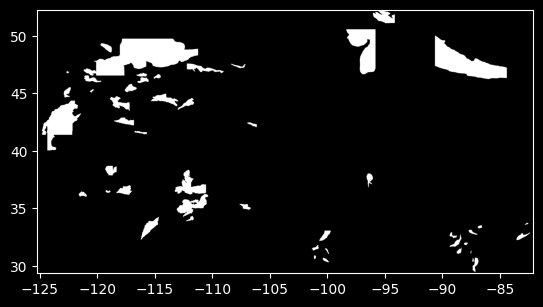

In [ ]:
try:
  mosaic,out_trans = merge.merge(stuff_to_mosaic[300:352])
  print("Shape:",mosaic[0].shape)
  show(mosaic,transform=out_trans,cmap="gray")
  plt.show()
  mosaiccount+=1
  with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=1,
            height= mosaic.shape[1],
            width= mosaic.shape[2],
            transform= out_trans,
            crs= src.crs,
            dtype= src.dtypes[0]) as dest:
    dest.write(mosaic)

except rio.errors.WindowError:
    print('"WindowError: Bounds and Transform are inconsistent" arises')

In [ ]:
print(conflicts)

[14, 77, 89, 102, 171, 211, 224, 247]


In [ ]:
try:
  conflictmos = merge.merge([stuff_to_mosaic[i] for i in conflicts])
except rio.errors.WindowError:
  print('"WindowError: Bounds and Transform are inconsistent" arises')

"WindowError: Bounds and Transform are inconsistent" arises


In [ ]:
bigconf = []
for i in conflicts:
  if stuff_to_mosaic[i].read().shape[1] and stuff_to_mosaic[i].read().shape[2]>=256:
    bigconf.append(stuff_to_mosaic[i])

Shape: (740, 651)


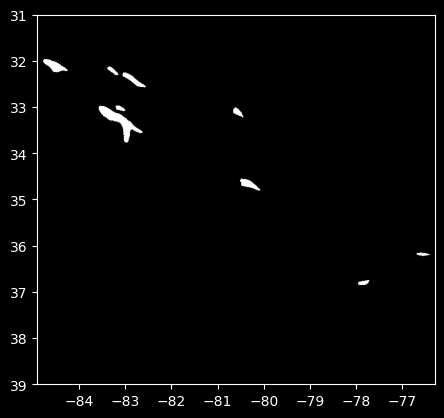

In [ ]:
mosaiccount+=1
for i in bigconf:
  with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=1,
            height= i.height,
            width = i.width,
            transform= i.transform,
            crs= i.crs,
            dtype= i.dtypes[0]) as dest:
    dest.write(i.read())
print("Shape:",i.shape)
show(i.read(),transform = i.transform,cmap="gray")
plt.show()

####Combination Mosaicking

Now that we know the masks with issues, we ignore them and use all the other masks and mosaic them again into sets of 10 to make a much larger dataset.

In [ ]:
cleaned_mosaic_stuff = [stuff_to_mosaic[i] for i in range(len(stuff_to_mosaic)) if i not in conflicts]

In [ ]:
for i in range(0,len(cleaned_mosaic_stuff),20):
    try:
        mosaic,out_trans = merge.merge(cleaned_mosaic_stuff[i:i+20])
        if mosaic.shape[1] and mosaic.shape[2] >=256:
          mosaiccount+=1
          with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=1,
                    height= mosaic.shape[1],
                    width= mosaic.shape[2],
                    transform= out_trans,
                    crs= src.crs,
                    dtype= src.dtypes[0]) as dest:
            dest.write(mosaic)
        else:
            pass
    except rio.errors.WindowError:
          print('"WindowError: Bounds and Transform are inconsistent" arises')

####Time based Mosaicking

Another way to mosaic is to mosaic using time. We utilized the timestamps on the mask images files and grouped them into sets of 10 days span. This is possible when we understand the timestamp format, which is **YYYY-DDD-hh:mm:ss.ms** where days are mapped throughout the range of 365 days.<br><br>An advantage of mosaicking using time is to generate seamless mosaics. If the images were taken over a large time span, there will be instances when the images overlap over each other and so will the masks, especially in our scenario when there are certain places where is emitted several times in a year like industrial plants. This can also cause data loss.

We will first seperate the conflicting images we found from the list of file paths as shown below, which we know cannot be used for mosaicking.

In [ ]:
conflicts = [i for i in sorted(os.listdir("/content/drive/MyDrive/bmp/")) if sorted(os.listdir("/content/drive/MyDrive/bmp/")).index(i) in conflicts]

In [ ]:
conflicts.append(os.listdir("/content/drive/MyDrive/bmp/")[293])
conflicts

['time-20170911923080-loc--86.6_30.2_-87.3_30.7.tif',
 'time-20172642100413-loc--109.2_41.6_-107.7_40.1.tif',
 'time-20172772015388-loc--119.3_37.3_-117.8_36.1.tif',
 'time-20172912015314-loc--84.9_39.0_-76.3_31.0.tif',
 'time-20181141915380-loc--82.7_29.3_-80.2_27.6.tif',
 'time-20190811915368-loc--85.3_35.4_-82.8_33.8.tif',
 'time-20190911915334-loc--82.4_32.9_-83.1_34.0.tif',
 'time-20191341910331-loc--104.2_22.3_-104.45_22.62.tif',
 'time-20172912015314-loc--102.6_46.0_-89.0_52.5.tif']

We now split the file-names and extract only the timestamps.

In [ ]:
groups = []
links = []
for filename in os.listdir("/content/drive/MyDrive/bmp/"):
  if filename not in conflicts:
      basename, extension = os.path.splitext(filename)
      project = basename.split('-')
      groups.append(project)
      links.append(filename)

In [ ]:
times = sorted([group[1] for group in groups])

We now have 343 masks that cannot cause problems in mosaicking and 343 timestamps to use.

In [ ]:
len(links)

343

In [ ]:
len(times)

343

In [ ]:
len(cleaned_mosaic_stuff)

343

We now create a list that holds sublists of all the groups of timestamps over 10 days each.

In [ ]:
times = list(np.unique([time[:6] for time in times]))

In [ ]:
len(times)

65

In [ ]:
timegrps = [[links[i] for i in range(len(links)) if groups[i][1][:6]==time] for time in times]

We now have 65 groups of timestamps which we can mosaic.

In [ ]:
len(timegrps)

65

In [ ]:
timermos = [[rio.open("/content/drive/MyDrive/bmp/"+i) for i in group] for group in timegrps]

The following shows one of the mosaics generated.

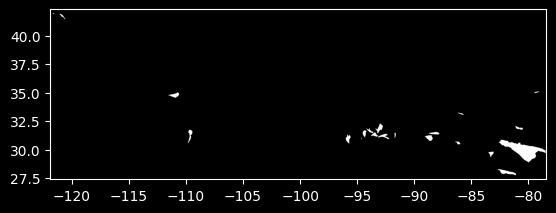

In [ ]:
show(merge.merge(timermos[5])[0][0],transform=merge.merge(timermos[5])[1],cmap="gray")
plt.show()

We will now try mosaicking the time grouped masks together and also check for WindowError.

In [ ]:
mosconf = []
for _ in timermos:
  try:
    mosaic, out_trans = merge.merge(_)
    if mosaic.shape[1]>=256 and mosaic.shape[2]>=256:
      mosaiccount += 1
      print(mosaic.shape)
      with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=1,
                height= mosaic.shape[1],
                width = mosaic.shape[2],
                transform= out_trans,
                crs= "EPSG:4326",
                dtype= src.dtypes[0]) as dest:
        dest.write(mosaic)
    else:
      pass
  except rio.errors.WindowError:
    print('"WindowError: Bounds and Transform are inconsistent" arises')
    mosconf.append(_)

(1, 865, 1189)
(1, 857, 1642)
(1, 821, 2220)
(1, 495, 2408)
(1, 1378, 3454)
(1, 270, 504)
(1, 1715, 3485)
(1, 785, 502)
(1, 1680, 1054)
(1, 1699, 1205)
(1, 1184, 2058)
(1, 934, 778)
(1, 765, 3038)
(1, 1599, 3417)
(1, 1034, 1367)
(1, 1505, 3029)
(1, 931, 940)
(1, 305, 457)
(1, 536, 842)
(1, 599, 326)
(1, 1086, 2463)
(1, 405, 1502)
(1, 1294, 1661)
(1, 350, 681)
(1, 701, 771)
(1, 1512, 1825)
(1, 1460, 3483)
(1, 608, 664)
(1, 499, 608)
(1, 2548, 554)
(1, 1202, 1375)
(1, 1110, 1312)
(1, 462, 443)
(1, 1572, 2039)
(1, 1018, 1839)
(1, 878, 2412)
(1, 555, 662)
(1, 1294, 1158)
(1, 990, 1399)
(1, 305, 366)
(1, 975, 1736)
(1, 350, 714)
(1, 1308, 1696)
(1, 2467, 3034)
(1, 3945, 3096)
(1, 3275, 2075)
(1, 1818, 2770)
(1, 3113, 623)
"WindowError: Bounds and Transform are inconsistent" arises
(1, 1792, 2658)
(1, 392, 466)
(1, 1668, 1608)
(1, 1243, 1069)
(1, 1686, 2414)
(1, 1586, 1556)
(1, 870, 2794)


Only one of the mosaic processes threw a WindowError, which we can ignore. Therefore the rest of the time groups were mosaicked successfully.

###Creating Corresponding Raster mosaics

We will now follow the exact process we performed for the masks and mosaic the rasters.

####Seperating inconsistent images

In [ ]:
stuff_to_mosaic = [rio.open("/content/drive/MyDrive/dataset/images/" + i) for i in sorted(os.listdir("/content/drive/MyDrive/dataset/images"))]
del stuff_to_mosaic[293]

In [ ]:
conflicts = []
mosaiccount = 0
outpath = "/content/drive/MyDrive/mosaics/Rasters/"

Shape: (1302, 2171)


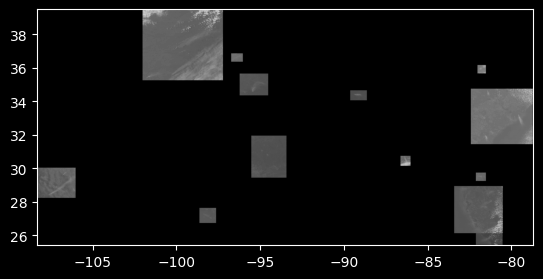

In [ ]:
try:
  mosaic,out_trans = merge.merge(stuff_to_mosaic[0:14])
  print("Shape:",mosaic[0].shape)
  show(mosaic[0],transform=out_trans,cmap="gray")
  plt.show()
  mosaiccount+=1
  with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=6,
            height= mosaic.shape[1],
            width= mosaic.shape[2],
            transform= out_trans,
            crs= src.crs,
            dtype= src.dtypes[0]) as dest:
    dest.write(mosaic)

except rio.errors.WindowError:
    print('"WindowError: Bounds and Transform are inconsistent" arises')

Shape: (46, 55)


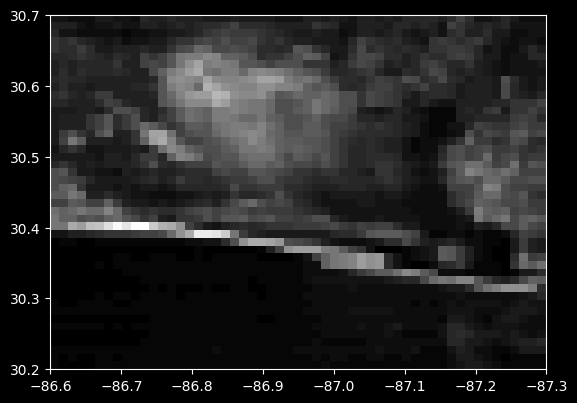

In [ ]:
print("Shape:",stuff_to_mosaic[14].read()[0].shape)
show(stuff_to_mosaic[14],transform=stuff_to_mosaic[14].transform,cmap="gray")
conflicts.append(14)
plt.show()

Shape: (2243, 3605)


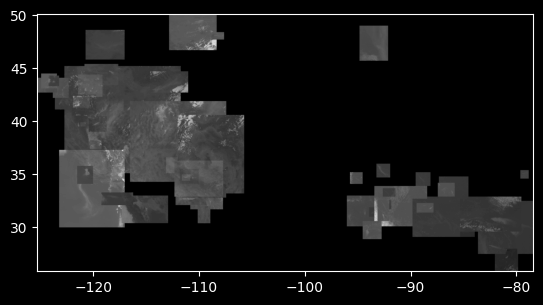

In [ ]:
try:
  mosaic,out_trans = merge.merge(stuff_to_mosaic[15:77])
  print("Shape:",mosaic[0].shape)
  show(mosaic[0],transform=out_trans,cmap="gray")
  plt.show()
  mosaiccount+=1
  with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=6,
            height= mosaic.shape[1],
            width= mosaic.shape[2],
            transform= out_trans,
            crs= src.crs,
            dtype= src.dtypes[0]) as dest:
    dest.write(mosaic)

except rio.errors.WindowError:
    print('"WindowError: Bounds and Transform are inconsistent" arises')

Shape: (138, 104)


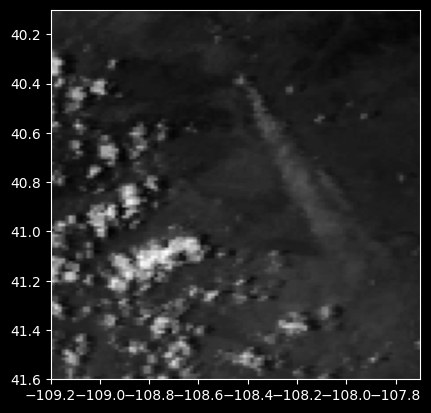

In [ ]:
print("Shape:",stuff_to_mosaic[77].read()[0].shape)
show(stuff_to_mosaic[77],transform=stuff_to_mosaic[77].transform,cmap="gray")
conflicts.append(77)
plt.show()

Shape: (1789, 3038)


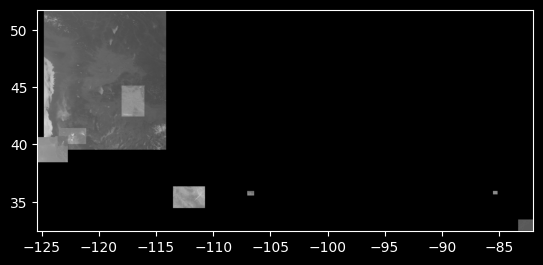

In [ ]:
try:
  mosaic,out_trans = merge.merge(stuff_to_mosaic[78:89])
  print("Shape:",mosaic[0].shape)
  show(mosaic[0],transform=out_trans,cmap="gray")
  plt.show()
  mosaiccount+=1
  with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=6,
            height= mosaic.shape[1],
            width= mosaic.shape[2],
            transform= out_trans,
            crs= src.crs,
            dtype= src.dtypes[0]) as dest:
    dest.write(mosaic)

except rio.errors.WindowError:
    print('"WindowError: Bounds and Transform are inconsistent" arises')

Shape: (110, 111)


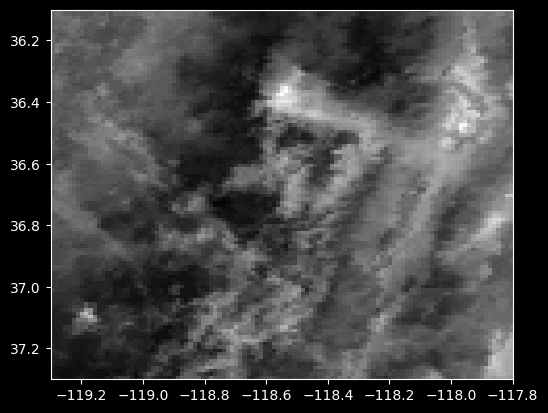

In [ ]:
print("Shape:",stuff_to_mosaic[89].read()[0].shape)
show(stuff_to_mosaic[89],transform = stuff_to_mosaic[89].transform,cmap="gray")
conflicts.append(89)
plt.show()

Shape: (2389, 3628)


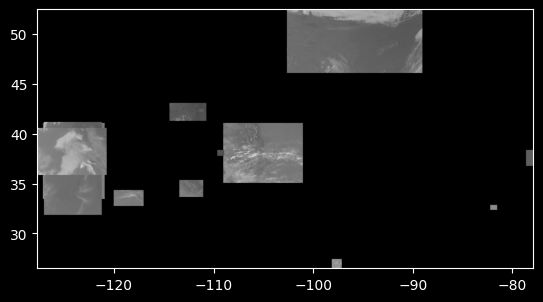

In [ ]:
try:
  mosaic,out_trans = merge.merge(stuff_to_mosaic[90:102])
  print("Shape:",mosaic[0].shape)
  show(mosaic[0],transform=out_trans,cmap="gray")
  plt.show()
  mosaiccount+=1
  with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=6,
            height= mosaic.shape[1],
            width= mosaic.shape[2],
            transform= out_trans,
            crs= src.crs,
            dtype= src.dtypes[0]) as dest:
    dest.write(mosaic)

except rio.errors.WindowError:
    print('"WindowError: Bounds and Transform are inconsistent" arises')

Shape: (740, 651)


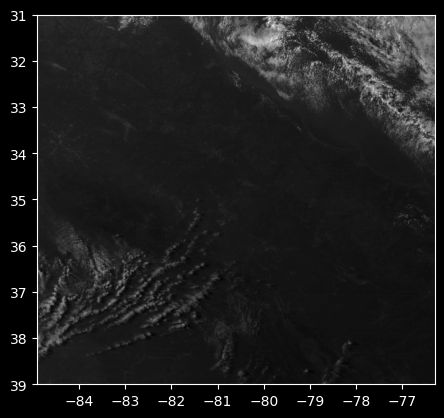

In [ ]:
print("Shape:",stuff_to_mosaic[102].read()[0].shape)
show(stuff_to_mosaic[102],transform = stuff_to_mosaic[102].transform,cmap="gray")
conflicts.append(102)
plt.show()

Shape: (2053, 3570)


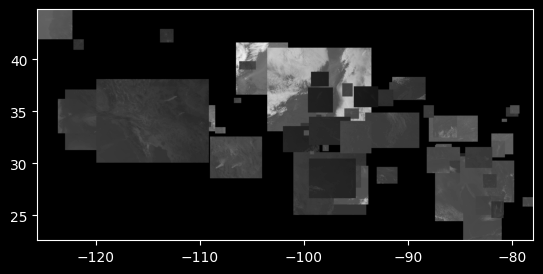

In [ ]:
try:
  mosaic,out_trans = merge.merge(stuff_to_mosaic[103:171])
  print("Shape:",mosaic[0].shape)
  show(mosaic[0],transform=out_trans,cmap="gray")
  plt.show()
  mosaiccount+=1
  with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=6,
            height= mosaic.shape[1],
            width= mosaic.shape[2],
            transform= out_trans,
            crs= src.crs,
            dtype= src.dtypes[0]) as dest:
    dest.write(mosaic)

except rio.errors.WindowError:
    print('"WindowError: Bounds and Transform are inconsistent" arises')

Shape: (157, 203)


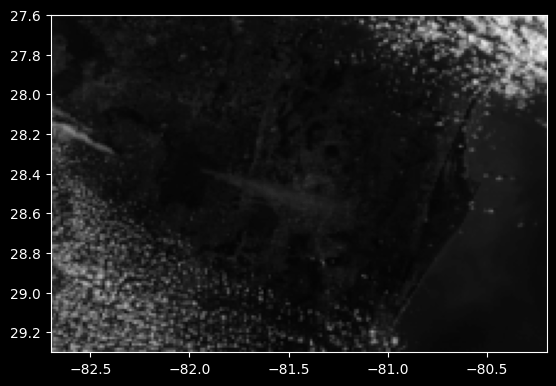

In [ ]:
print("Shape:",stuff_to_mosaic[171].read()[0].shape)
show(stuff_to_mosaic[171],transform = stuff_to_mosaic[171].transform,cmap="gray")
conflicts.append(171)
plt.show()

Shape: (3121, 4309)


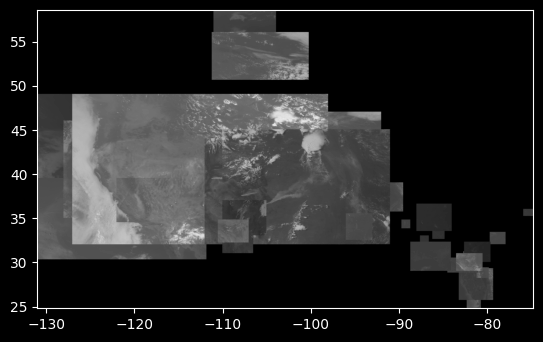

In [ ]:
try:
  mosaic,out_trans = merge.merge(stuff_to_mosaic[172:211])
  print("Shape:",mosaic[0].shape)
  show(mosaic[0],transform=out_trans,cmap="gray")
  plt.show()
  mosaiccount+=1
  with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=6,
            height= mosaic.shape[1],
            width= mosaic.shape[2],
            transform= out_trans,
            crs= src.crs,
            dtype= src.dtypes[0]) as dest:
    dest.write(mosaic)

except rio.errors.WindowError:
    print('"WindowError: Bounds and Transform are inconsistent" arises')

Shape: (148, 190)


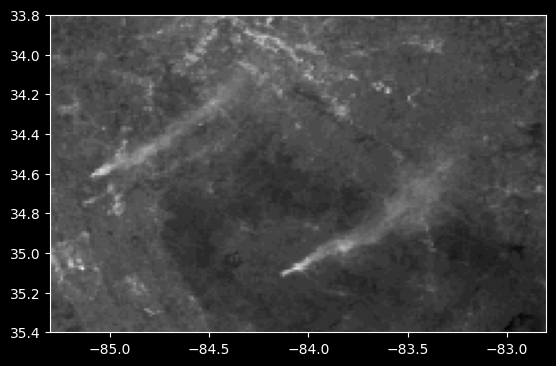

In [ ]:
print("Shape:",stuff_to_mosaic[211].read()[0].shape)
show(stuff_to_mosaic[211].read()[0],transform = stuff_to_mosaic[211].transform,cmap="gray")
conflicts.append(211)
plt.show()

Shape: (697, 1660)


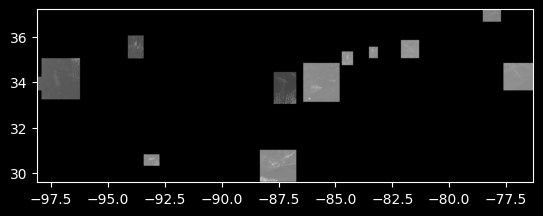

In [ ]:
try:
  mosaic,out_trans = merge.merge(stuff_to_mosaic[212:224])
  print("Shape:",mosaic[0].shape)
  show(mosaic[0],transform=out_trans,cmap="gray")
  plt.show()
  mosaiccount+=1
  with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=6,
            height= mosaic.shape[1],
            width= mosaic.shape[2],
            transform= out_trans,
            crs= src.crs,
            dtype= src.dtypes[0]) as dest:
    dest.write(mosaic)

except rio.errors.WindowError:
    print('"WindowError: Bounds and Transform are inconsistent" arises')

Shape: (101, 54)


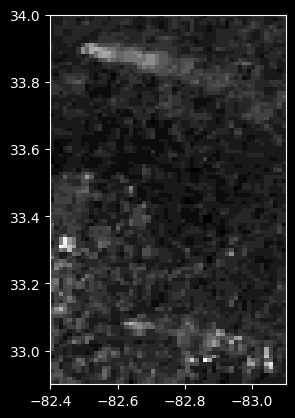

In [ ]:
print("Shape:",stuff_to_mosaic[224].read()[0].shape)
show(stuff_to_mosaic[224],transform = stuff_to_mosaic[224].transform,cmap="gray")
conflicts.append(224)
plt.show()

Shape: (2658, 3124)


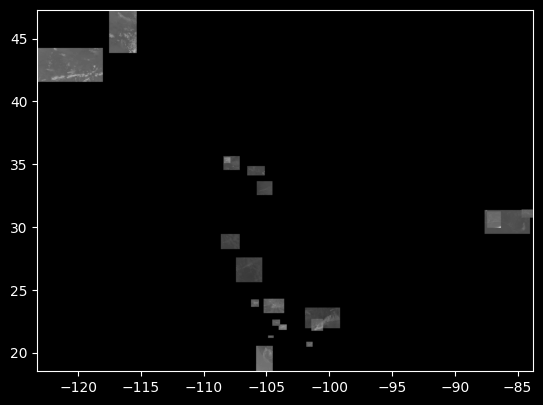

In [ ]:
try:
  mosaic,out_trans = merge.merge(stuff_to_mosaic[225:247])
  print("Shape:",mosaic[0].shape)
  show(mosaic[0],transform=out_trans,cmap="gray")
  plt.show()
  mosaiccount+=1
  with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=6,
            height= mosaic.shape[1],
            width= mosaic.shape[2],
            transform= out_trans,
            crs= src.crs,
            dtype= src.dtypes[0]) as dest:
    dest.write(mosaic)

except rio.errors.WindowError:
    print('"WindowError: Bounds and Transform are inconsistent" arises')

Shape: (29, 21)


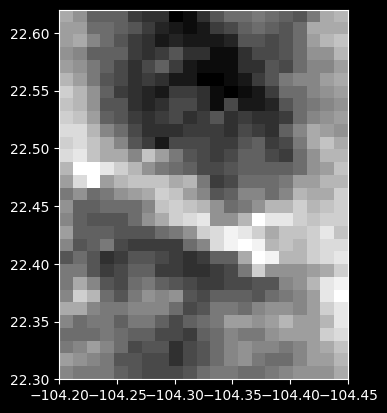

In [ ]:
print("Shape:",stuff_to_mosaic[247].read()[0].shape)
show(stuff_to_mosaic[247],transform = stuff_to_mosaic[247].transform,cmap="gray")
conflicts.append(247)
plt.show()

Shape: (3915, 3732)


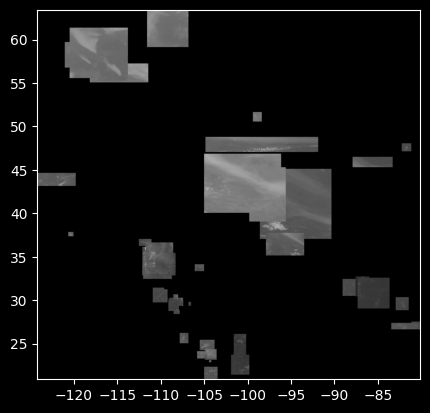

In [ ]:
try:
  mosaic,out_trans = merge.merge(stuff_to_mosaic[248:300])
  print("Shape:",mosaic[0].shape)
  show(mosaic[0],transform=out_trans,cmap="gray")
  plt.show()
  mosaiccount+=1
  with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=6,
            height= mosaic.shape[1],
            width= mosaic.shape[2],
            transform= out_trans,
            crs= src.crs,
            dtype= src.dtypes[0]) as dest:
    dest.write(mosaic)

except rio.errors.WindowError:
    print('"WindowError: Bounds and Transform are inconsistent" arises')

Shape: (2111, 3263)


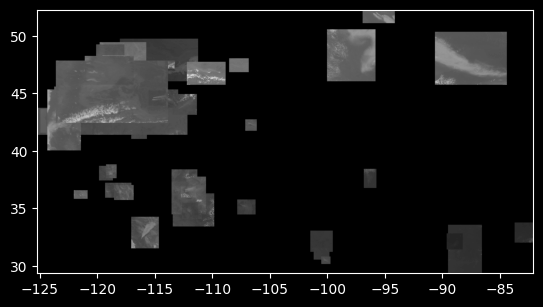

In [ ]:
try:
  mosaic,out_trans = merge.merge(stuff_to_mosaic[300:352])
  print("Shape:",mosaic[0].shape)
  show(mosaic[0],transform=out_trans,cmap="gray")
  plt.show()
  mosaiccount+=1
  with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=6,
            height= mosaic.shape[1],
            width= mosaic.shape[2],
            transform= out_trans,
            crs= src.crs,
            dtype= src.dtypes[0]) as dest:
    dest.write(mosaic)

except rio.errors.WindowError:
    print('"WindowError: Bounds and Transform are inconsistent" arises')

In [ ]:
print(conflicts)

[14, 77, 89, 102, 171, 211, 224, 247]


In [ ]:
try:
  conflictmos = merge.merge([stuff_to_mosaic[i] for i in conflicts])
except rio.errors.WindowError:
  print('"WindowError: Bounds and Transform are inconsistent" arises')

"WindowError: Bounds and Transform are inconsistent" arises


In [ ]:
bigconf = []
for i in conflicts:
  if stuff_to_mosaic[i].read().shape[1] and stuff_to_mosaic[i].read().shape[2]>=256:
    bigconf.append(stuff_to_mosaic[i])

Shape: (740, 651)


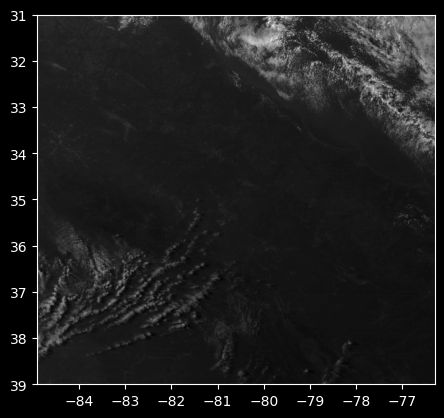

In [ ]:
mosaiccount+=1
for i in bigconf:
  with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=6,
            height= i.height,
            width = i.width,
            transform= i.transform,
            crs= i.crs,
            dtype= i.dtypes[0]) as dest:
    dest.write(i.read())
print("Shape:",i.shape)
show(i,cmap="gray")
plt.show()

####Combination Mosaicking

The first is for sets of 10, removing the conflicts

In [ ]:
cleaned_mosaic_stuff = [stuff_to_mosaic[i] for i in range(len(stuff_to_mosaic)) if i not in conflicts]

In [ ]:
for i in range(0,len(cleaned_mosaic_stuff),20):
    try:
        mosaic,out_trans = merge.merge(cleaned_mosaic_stuff[i:i+20])
        if mosaic.shape[1] and mosaic.shape[2] >=256:
          mosaiccount+=1
          with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=6,
                    height= mosaic.shape[1],
                    width= mosaic.shape[2],
                    transform= out_trans,
                    crs= src.crs,
                    dtype= src.dtypes[0]) as dest:
            dest.write(mosaic)
        else:
            pass
    except rio.errors.WindowError:
          print('"WindowError: Bounds and Transform are inconsistent" arises')

In [ ]:
for i in os.listdir("/content/drive/MyDrive/mosaics/Rasters"):
  samp = rio.open("/content/drive/MyDrive/mosaics/Rasters/"+i)
  print(samp.read().shape)

(6, 1302, 2171)
(6, 2243, 3605)
(6, 1789, 3038)
(6, 2389, 3628)
(6, 2053, 3570)
(6, 3121, 4309)
(6, 697, 1660)
(6, 2658, 3124)
(6, 3915, 3732)
(6, 2111, 3263)
(6, 740, 651)
(6, 1302, 2171)
(6, 1375, 3294)
(6, 1779, 3549)
(6, 1866, 3045)
(6, 2399, 3541)
(6, 1495, 3455)
(6, 1580, 3315)
(6, 1743, 2572)
(6, 2723, 3729)
(6, 2155, 3829)
(6, 1312, 2213)
(6, 2661, 3254)
(6, 3717, 3427)
(6, 3398, 2274)
(6, 2157, 2899)
(6, 1760, 2431)
(6, 1580, 2762)
(6, 859, 2613)


####Time based Mosaicking

In [ ]:
conflicts = [i for i in sorted(os.listdir("/content/drive/MyDrive/wgs84/")) if sorted(os.listdir("/content/drive/MyDrive/wgs84/")).index(i) in conflicts]

In [ ]:
conflicts.append(os.listdir("/content/drive/MyDrive/wgs84/")[293])
conflicts

['time-20170911923080-loc--86.6_30.2_-87.3_30.7.tif',
 'time-20172642100413-loc--109.2_41.6_-107.7_40.1.tif',
 'time-20172772015388-loc--119.3_37.3_-117.8_36.1.tif',
 'time-20172912015314-loc--84.9_39.0_-76.3_31.0.tif',
 'time-20181141915380-loc--82.7_29.3_-80.2_27.6.tif',
 'time-20190811915368-loc--85.3_35.4_-82.8_33.8.tif',
 'time-20190911915334-loc--82.4_32.9_-83.1_34.0.tif',
 'time-20191341910331-loc--104.2_22.3_-104.45_22.62.tif',
 'time-20192332310210-loc--113.4_33.4_-109.8_36.28.tif']

In [ ]:
groups = []
links = []
for filename in os.listdir("/content/drive/MyDrive/wgs84/"):
  if filename not in conflicts:
      basename, extension = os.path.splitext(filename)
      project = basename.split('-')
      groups.append(project)
      links.append(filename)

In [ ]:
times = sorted([group[1] for group in groups])

In [ ]:
len(links)

343

In [ ]:
len(times)

343

In [ ]:
len(cleaned_mosaic_stuff)

343

In [ ]:
times = list(np.unique([time[:6] for time in times]))

In [ ]:
len(times)

65

In [ ]:
timegrps = [[links[i] for i in range(len(links)) if groups[i][1][:6]==time] for time in times]

In [ ]:
len(timegrps)

65

In [ ]:
timermos = [[rio.open("/content/drive/MyDrive/wgs84/"+i) for i in group] for group in timegrps]

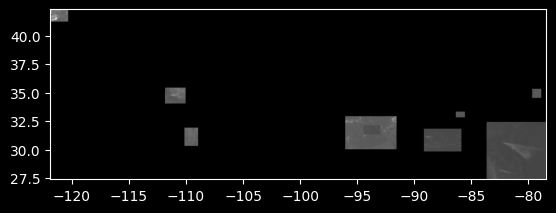

<Axes: >

In [ ]:
show(merge.merge(timermos[5])[0][0],transform=merge.merge(timermos[5])[1],cmap="gray")

In [ ]:
for _ in timermos:
  if _ not in mosconf:
    try:
      mosaic, out_trans = merge.merge(_)
      if mosaic.shape[1]>=256 and mosaic.shape[2]>=256:
        mosaiccount += 1
        print(mosaic.shape)
        with rio.open(outpath+str(mosaiccount),"w", driver ='Gtiff',count=6,
                  height= mosaic.shape[1],
                  width = mosaic.shape[2],
                  transform= out_trans,
                  crs= "EPSG:4326",
                  dtype= src.dtypes[0]) as dest:
          dest.write(mosaic)
      else:
        pass
    except rio.errors.WindowError:
      print('"WindowError: Bounds and Transform are inconsistent" arises')
  else:
    pass

(6, 801, 1364)
(6, 829, 1774)
(6, 750, 2394)
(6, 440, 2613)
(6, 1304, 3807)
(6, 1510, 3693)
(6, 384, 259)
(6, 704, 538)
(6, 1499, 1104)
(6, 1588, 1381)
(6, 1025, 2268)
(6, 822, 895)
(6, 666, 3482)
(6, 1410, 3799)
(6, 957, 1606)
(6, 2061, 3218)
(6, 835, 1026)
(6, 265, 481)
(6, 466, 883)
(6, 573, 370)
(6, 959, 2903)
(6, 370, 1640)
(6, 1229, 1869)
(6, 312, 729)
(6, 654, 809)
(6, 1365, 1961)
(6, 1341, 3827)
(6, 555, 706)
(6, 347, 706)
(6, 2280, 587)
(6, 1031, 1507)
(6, 953, 1430)
(6, 410, 492)
(6, 1302, 2221)
(6, 810, 1988)
(6, 732, 2729)
(6, 479, 719)
(6, 1144, 1307)
(6, 850, 1525)
(6, 278, 387)
(6, 902, 1914)
(6, 316, 781)
(6, 1184, 1817)
(6, 2335, 3432)
(6, 3796, 3260)
(6, 3057, 3526)
(6, 1522, 3330)
(6, 2070, 505)
(6, 689, 8450)
(6, 1643, 3056)
(6, 358, 518)
(6, 1404, 1984)
(6, 979, 1236)
(6, 1581, 2678)
(6, 1393, 1594)
(6, 800, 3198)


##Tiling

Now that we have created a bunch of mosaicked images, we can tile them into images of size **256 x 256**. We need to ensure that fulfil the following criteria:<br>


*   Should not have too less image information and too much redundant black regions obtained from georeferencing.
*   Should not have too many or too less images so as to avoid overfitting and underfitting



The necessary file paths are aas follows:

In [ ]:
rasmospath = "/content/drive/MyDrive/mosaics/Rasters/"
maskmospath =  "/content/drive/MyDrive/mosaics/Masks/"

rastilpath = "/content/drive/MyDrive/Tiles/Rasters/"
masktilpath =  "/content/drive/MyDrive/Tiles/Masks/"

Using ```rasterio.windows.Window```, we can create slices of the image and make new images from this. Below shows an example of using ``Window`` objects to create a tile.


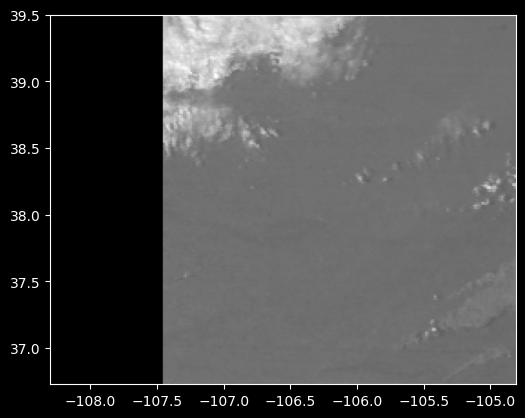

<Axes: >

In [ ]:
window = rio.windows.Window(400, 0, 256, 256)
show(rio.open(rasmospath+ os.listdir(rasmospath)[0]).read(window = window)[0],transform = rio.open(rasmospath+ os.listdir(rasmospath)[0]).transform,cmap="gray")
plt.show()

Now to fulfil the criteria, we can parse through the mosaics and with each window we generate, we must check if it has more of the non-raster black regions over the actual raster images, and if it doesnt, we can consider it to be a tile of use, and we can hence add it to our final dataset.

In [ ]:
tilecount=0
for mosaic,masmos in zip(os.listdir(rasmospath),os.listdir(maskmospath)):
  mosaic = rio.open(rasmospath + mosaic)
  masmos = rio.open(maskmospath + masmos)
  for i in range(0,mosaic.height,256):
    for j in range(0,mosaic.width,256):
      window = rio.windows.Window(j, i, 256, 256)
      array = mosaic.read(window=window)
      num_zeros = np.count_nonzero(array==0)
      total_elements = np.product(array.shape)

      if num_zeros <= total_elements / 2:
        tilecount+=1
        transform = mosaic.window_transform(window)
        profile = mosaic.profile
        profile.update({
            'height': 256,
            'width': 256,
            'transform': transform,
            'count': mosaic.count})
        with rio.open(rastilpath+str(tilecount), 'w', **profile) as dst:
            dst.write(mosaic.read(window=window))
        transform = masmos.window_transform(window)
        profile = masmos.profile
        profile.update({
            'height': 256,
            'width': 256,
            'transform': transform,
            'count': masmos.count})
        with rio.open(masktilpath+str(tilecount), 'w', **profile) as dst:
            dst.write(masmos.read(window=window))
      else:
        pass

The following shows how many 256x256 sized tiles have been generated.

In [ ]:
len(os.listdir(rastilpath))

1050

In [ ]:
len(os.listdir(masktilpath))

1050

##Conclusion

In conclusion, we have managed to generate a mosaicked and tiled dataset consisting of 1050 images, which we will utilize to create segmentation models that can detect smoke. While we seem to have a good dataset in theory, we will now test this dataset's efficacy by testing in practicality in the following notebooks.